In [1]:
import pandas as pd
import numpy as np
import zipfile
import urllib.request
import os
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances
from warnings import filterwarnings

filterwarnings('ignore')


# Human Activity Recognition Dataset Preparation
Overview:
This document explains how to prepare and load the Human Activity Recognition Using Smartphones dataset for analysis and implementation of a self-organizing map (SOM). The dataset includes high-dimensional sensor data suitable for clustering and dimensionality reduction tasks.

## Steps
### Step 1: Download the Dataset
Obtain the dataset from the UCI Machine Learning Repository in a ZIP file format.
Check if the ZIP file already exists locally to avoid re-downloading.
If the file does not exist, download it using the provided URL.
### Step 2: Extract the Main ZIP File
Unpack the primary ZIP file into a directory named human_activity_recognition.
This process makes the dataset contents accessible for further extraction.
### Step 3: Extract the Inner Dataset ZIP File
Within the extracted contents, locate another ZIP file named UCI HAR Dataset.zip.
Extract this inner ZIP file to make the dataset files, such as training and testing data, directly accessible.
### Step 4: Load the Training and Testing Data
Locate the paths for the training data (X_train.txt) and labels (y_train.txt) within the train directory.
Similarly, find the testing data (X_test.txt) and labels (y_test.txt) within the test directory.
Load the datasets using a library like pandas for structured data handling.
### Step 5: Combine Training and Testing Data
Concatenate the training and testing datasets to create a unified dataset for further processing.
Similarly, merge the labels for consistent alignment with the data.

In [15]:
# Step 1: Download the dataset zip file
url = "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"
zip_file = "human_activity_recognition.zip"

if not os.path.exists(zip_file):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, zip_file)

# Step 2: Extract the dataset
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("human_activity_recognition")

# Step 3: Extract the inner dataset zip file
inner_zip_path = "human_activity_recognition/UCI HAR Dataset.zip"
if os.path.exists(inner_zip_path):
    with zipfile.ZipFile(inner_zip_path, 'r') as zip_ref:
        zip_ref.extractall("./UCI HAR Dataset")

# Step 4: Load the training and testing data
train_data_path = "UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt"
train_labels_path = "UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt"
test_data_path = "UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt"
test_labels_path = "UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt"

# Load the datasets
train_data = pd.read_csv(train_data_path, sep='\s+', header=None)
train_labels = pd.read_csv(train_labels_path, header=None)
test_data = pd.read_csv(test_data_path, sep='\s+', header=None)
test_labels = pd.read_csv(test_labels_path, header=None)

# Step 5: Combine training and testing data for further processing
data = pd.concat([train_data, test_data], ignore_index=True)
labels = pd.concat([train_labels, test_labels], ignore_index=True)

# Display the dimensions and a sample of the dataset
print("Dimensions of the dataset:", data.shape)
data.head()

Dimensions of the dataset: (10299, 561)


,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [3]:
def purity_score(labels_true, labels_pred):
    """
    Calculate the Purity score between the true labels and predicted labels.
    Args:
        labels_true (array-like): True labels.
        labels_pred (array-like): Predicted labels from clustering.
    Returns:
        purity (float): The Purity score.
    """
    # Get unique clusters
    clusters = np.unique(labels_pred)
    purity = 0

    # Iterate through each cluster
    for cluster in clusters:
        # Get the true labels for the current cluster
        cluster_true_labels = labels_true[labels_pred == cluster]
        # Find the most common true label in this cluster
        most_common_label = Counter(cluster_true_labels).most_common(1)[0][0]
        # Add the number of correctly classified samples in the cluster
        purity += np.sum(cluster_true_labels == most_common_label)

    # Return the purity as a fraction of the total samples
    return purity / len(labels_true)

In [7]:
def intra_cluster_distance(data, clusters, som):
    distances = []
    for cluster in np.unique(clusters):
        # Convert the cluster index back to a 2D index using np.unravel_index
        cluster_idx = np.unravel_index(cluster, som.grid_shape)
        cluster_data = data[clusters == cluster]
        cluster_center = som.weights[cluster_idx]  # Access the cluster center using 2D index
        cluster_distances = np.linalg.norm(cluster_data - cluster_center, axis=1)
        distances.extend(cluster_distances)
    return np.mean(distances)

def inter_cluster_distance(clusters, som):
    distances = []
    cluster_centers = []
    for cluster in np.unique(clusters):
        # Convert the cluster index back to a 2D index using np.unravel_index
        cluster_idx = np.unravel_index(cluster, som.grid_shape)
        cluster_center = som.weights[cluster_idx]  # Access the cluster center using 2D index
        cluster_centers.append(cluster_center)

    for i, cluster1 in enumerate(cluster_centers):
        for j, cluster2 in enumerate(cluster_centers):
            if i < j:
                distance = np.linalg.norm(cluster1 - cluster2)
                distances.append(distance)

    return np.mean(distances)

def quantization_error(data, clusters, som):
    error = 0
    for i, sample in enumerate(data):
        cluster = clusters[i]
        # Convert cluster to 2D index
        cluster_idx = np.unravel_index(cluster, som.grid_shape)
        bmu_weight = som.weights[cluster_idx]  # Access the BMU weight using 2D index
        error += np.linalg.norm(sample - bmu_weight)
    return error / len(data)

def reconstruction_error(data, clusters, som):
    error = 0
    for i, sample in enumerate(data):
        cluster = clusters[i]
        # Convert cluster to 2D index
        cluster_idx = np.unravel_index(cluster, som.grid_shape)
        bmu_weight = som.weights[cluster_idx]  # Access the BMU weight using 2D index
        error += np.linalg.norm(sample - bmu_weight)
    return error / len(data)

def evaluate_clustering(data, labels, clusters, som):
    # Intra-cluster Distance
    intra_cluster_dist = intra_cluster_distance(data, clusters, som)
    print(f"Intra-cluster Distance: {intra_cluster_dist}")

    # Inter-cluster Distance
    inter_cluster_dist = inter_cluster_distance(clusters, som)
    print(f"Inter-cluster Distance: {inter_cluster_dist}")

    # Silhouette Score
    silhouette_avg = silhouette_score(data, clusters)
    print(f"Silhouette Score: {silhouette_avg}")

    # Quantization Error
    quant_error = quantization_error(data, clusters, som)
    print(f"Quantization Error: {quant_error}")

    # Reconstruction Error
    reconstruction_err = reconstruction_error(data, clusters, som)
    print(f"Reconstruction Error: {reconstruction_err}")

    # Purity
    purity = purity_score(labels, clusters)
    print(f"Purity: {purity}")

# Self-Organizing Map Implementation
## Overview
This document describes the implementation of a Self-Organizing Map (SOM) using Python. SOM is an unsupervised neural network algorithm used for dimensionality reduction, clustering, and visualization of high-dimensional data. This implementation includes training, visualization, and evaluation of the SOM.

## Steps
### Step 1: Initialize the Self-Organizing Map
Grid Dimensions: Specify the size of the SOM grid (e.g., 10x10 for a 2D grid).
Input Dimension: Define the dimensionality of the input data.
Parameters: Set the learning rate, neighborhood radius, and maximum number of iterations.
Weight Initialization: Initialize the weights randomly in a grid with dimensions matching the SOM grid and input features.
### Step 2: Define Utility Functions
Euclidean Distance: Compute the distance between two points in multidimensional space.
Neighborhood Function: Use a Gaussian function to determine the influence of the Best Matching Unit (BMU) on its neighbors during training.
Find Best Matching Unit (BMU): Identify the neuron whose weight vector is closest to the input sample.
### Step 3: Implement Weight Updates
Update the weights of the BMU and its neighbors based on their distance from the BMU and the neighborhood function.
Gradually decrease the learning rate and neighborhood radius over iterations to fine-tune the SOM.
### Step 4: Train the SOM
Randomly sample inputs from the dataset during each training iteration.
Find the BMU for each sample and update the weights of the BMU and its neighbors.
Log progress and visualize the SOM at regular intervals.
### Step 5: Visualize SOM Results
Use a grid-based approach to visualize how data points are clustered in the SOM grid.
Map input labels to colors for better interpretability of clusters.
Create combined visualizations at specific epochs to monitor the evolution of the SOM during training.
### Step 6: Evaluate Clustering
After training, map each input sample to its corresponding BMU and assign a cluster label.
Evaluate the effectiveness of clustering using external methods (e.g., purity, silhouette score).

# Explanation of Key Concepts
### Winning Neuron (BMU):
 The neuron in the SOM grid with the smallest distance to the input vector.
### Neighborhood Function:
 Determines the influence of the BMU on its neighbors, ensuring that updates affect nearby neurons more significantly in the early stages of training.
### Weight Update Rule:
 Adjusts the weights of neurons to make them more similar to the input vectors over time.


## Parameters
* Grid Shape: (rows, columns) for the SOM grid.
* Input Dimensionality: Number of features in the dataset.
* Learning Rate: Initial value, decays over time.
* Neighborhood Radius: Determines the influence range, also decays over time.
* Max Iterations: Total number of training steps.

In [8]:
class SelfOrganizingMap:
    def __init__(self, grid_shape, input_dim, learning_rate=0.5, radius=1.0, max_iter=1000, neighborhood_func=None):
        """
        Initialize the SOM.
        Args:
            grid_shape (tuple): Shape of the SOM grid (rows, columns).
            input_dim (int): Dimensionality of the input data.
            learning_rate (float): Initial learning rate.
            radius (float): Initial neighborhood radius.
            max_iter (int): Maximum number of iterations for training.
            neighborhood_func (callable): Custom neighborhood function.
        """
        self.grid_shape = grid_shape
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.radius = radius
        self.max_iter = max_iter
        self.neighborhood_func = neighborhood_func or self._default_neighborhood
        self.weights = np.random.rand(grid_shape[0], grid_shape[1], input_dim)
        self.time_constant = max_iter / np.log(radius)

    def _euclidean_distance(self, x, y):
        """Calculate the Euclidean distance between two vectors."""
        return np.linalg.norm(x - y)

    def _default_neighborhood(self, distance, radius):
        """Default Gaussian neighborhood function."""
        return np.exp(-(distance**2) / (2 * (radius**2)))

    def _find_bmu(self, sample):
        """Find the Best Matching Unit (BMU) for a given sample."""
        distances = np.linalg.norm(self.weights - sample, axis=2)
        return np.unravel_index(np.argmin(distances), self.grid_shape)

    def _update_weights(self, sample, bmu_idx, iteration):
        """Update the weights of the BMU and its neighbors."""
        lr = self.learning_rate * np.exp(-iteration / self.max_iter)
        radius_decay = self.radius * np.exp(-iteration / self.time_constant)
        for i in range(self.grid_shape[0]):
            for j in range(self.grid_shape[1]):
                # Calculate the distance to the BMU
                distance_to_bmu = self._euclidean_distance(np.array([i, j]), np.array(bmu_idx))
                influence = self.neighborhood_func(distance_to_bmu, radius_decay)
                if influence > 0:
                    self.weights[i, j] += lr * influence * (sample - self.weights[i, j])

    def visualize_combined(self, data, labels, epochs, save_path="som_combined_visualization"):
        """
        Visualize the clustering results for multiple epochs in a single image.
        Args:
            data (ndarray): Input data array with shape (n_samples, input_dim).
            labels (ndarray): Labels corresponding to the data points.
            epochs (list): List of epochs at which to visualize the clustering.
            save_path (str): Path to save the generated plot.
        """
        num_plots = len(epochs)
        cols = 5  # Number of columns for subplots
        rows = (num_plots + cols - 1) // cols  # Determine rows dynamically based on the number of plots

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
        axes = axes.flatten()

        for idx, epoch in enumerate(epochs):
            scores = np.zeros(shape=(self.grid_shape[0], self.grid_shape[1], 3))  # RGB visualization
            for i, sample in enumerate(data):
                bmu_idx = self._find_bmu(sample)
                iw, jw = bmu_idx[0], bmu_idx[1]
                if labels[i] == 1:
                    scores[iw, jw] += np.asarray([1, 0, 0])
                elif labels[i] == 2:
                    scores[iw, jw] += np.asarray([0, 0, 1])
                elif labels[i] == 3:
                    scores[iw, jw] += np.asarray([0, 1, 0])
                elif labels[i] == 4:
                    scores[iw, jw] += np.asarray([1, 1, 0])
                elif labels[i] == 5:
                    scores[iw, jw] += np.asarray([0, 1, 1])
                elif labels[i] == 6:
                    scores[iw, jw] += np.asarray([1, 0, 1])

            ax = axes[idx]
            ax.imshow(scores / scores.max())  # Normalize for visualization
            ax.set_title(f"Epoch {epoch}")
            ax.axis('off')

        # Remove any extra subplots if epochs are fewer than the grid size
        for ax in axes[len(epochs):]:
            ax.axis('off')

        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}.png")
        plt.show()

    def train(self, data, labels, visualize_every=100, save_path=None):
        """
        Train the SOM and visualize multiple epochs in a single image.
        Args:
            data (ndarray): Input data array with shape (n_samples, input_dim).
            labels (ndarray): Labels corresponding to the data points.
            visualize_every (int): Interval (in epochs) to include in the combined visualization.
            save_path (str): Path to save the combined visualization plot.
        """
        epochs_to_visualize = []
        for iteration in range(self.max_iter):
            sample = data[np.random.randint(0, data.shape[0])]
            bmu_idx = self._find_bmu(sample)
            self._update_weights(sample, bmu_idx, iteration)
            if (iteration + 1) % visualize_every == 0:
                epochs_to_visualize.append(iteration + 1)

        # Call the combined visualization method after training
        if epochs_to_visualize:
            print("Creating combined visualization...")
            self.visualize_combined(data, labels, epochs_to_visualize, save_path)

        # Get the clusters by finding the BMU for each sample
        clusters = []
        for sample in data:
            bmu_idx = self._find_bmu(sample)  # This gives the 2D BMU index
            clusters.append(bmu_idx)  # Store the 2D index as a tuple

        clusters = np.array(clusters)  # Now clusters is a 2D array with shape (n_samples, 2)

        # Convert clusters to 1D array of cluster indices (this step is required)
        cluster_labels = np.array([np.ravel_multi_index(cluster, self.grid_shape) for cluster in clusters])

        # Evaluate clustering effectiveness
        print("Evaluating clustering effectiveness...")
        evaluate_clustering(data, labels, cluster_labels, self)

        print("Training completed.")


# Experiments and Results with Self-Organizing Maps

### Experiment Objective
* Train the SOM with at least three different grid sizes: 5x5, 10x10, and 15x15.
* Visualize the 2D representation of the data for each network size.
* Analyze the number of dead neurons in each case and their impact on clustering performance.

# Steps
## Step 1: Define Grid Sizes
Grid sizes used:
* 5x5
* 10x10
* 15x15

## Step 2: Train SOM
Each SOM was trained on the dataset with the following parameters:
* Input Dimensionality: Matches the dataset's feature count.
* Learning Rate: 0.5
* Neighborhood Radius: 2.0
* Max Iterations: 1000

## Step 3: Count Dead Neurons
Dead neurons are defined as neurons that are not mapped to any data point during training.
Counted using the frequency of data point mappings.
## Step 4: Visualize Results
For each grid size, visualize the SOM weight map.
Plot the number of dead neurons against the grid sizes.


# Results
## Performance Metrics
For each grid size, the following metrics were computed:

* Intra-cluster Distance: Measures the compactness of clusters.
* Inter-cluster Distance: Measures the separation between clusters.
* Silhouette Score: Evaluates cluster quality (higher is better).
* Quantization Error: Measures the difference between input vectors and their BMUs.
* Reconstruction Error: Similar to quantization error but computed differently.
* Purity: Measures how effectively the clusters match the ground truth labels.


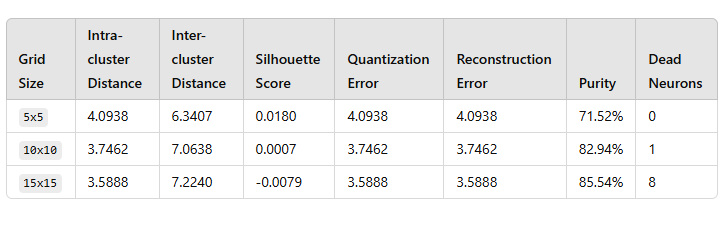



# Observations
## Clustering Performance:

* As the grid size increases, the intra-cluster distance decreases, indicating tighter clusters.
* Inter-cluster distance increases, improving separation between clusters.
* Purity improves with larger grid sizes, suggesting better alignment with ground truth labels.

## Dead Neurons:
* Smaller grids (5x5) had no dead neurons, indicating full utilization of neurons.
* Larger grids (15x15) had more dead neurons (8), due to sparse data mapping in higher dimensions.
* Silhouette Score:

Decreased slightly with larger grids, indicating marginally overlapping clusters.
* Visualization:

The weight maps showed progressively finer representation of the data with larger grids, reflecting more detailed clustering.

# Graph: Dead Neurons Across Grid Sizes
A plot of the number of dead neurons for each grid size.

* X-axis: Grid sizes (5x5, 10x10, 15x15)
* Y-axis: Number of Dead Neurons

# Conclusion
* Larger grid sizes provide finer and more precise clustering but are prone to dead neurons, especially when the data density is low.
* Smaller grids maximize neuron utilization but may result in less detailed data representation.
* Choosing an optimal grid size involves balancing the trade-off between clustering detail and neuron utilization. For this dataset, a 10x10 grid offered the best balance with minimal dead neurons and high purity.

Training SOM with grid size (5, 5)...
Creating combined visualization...


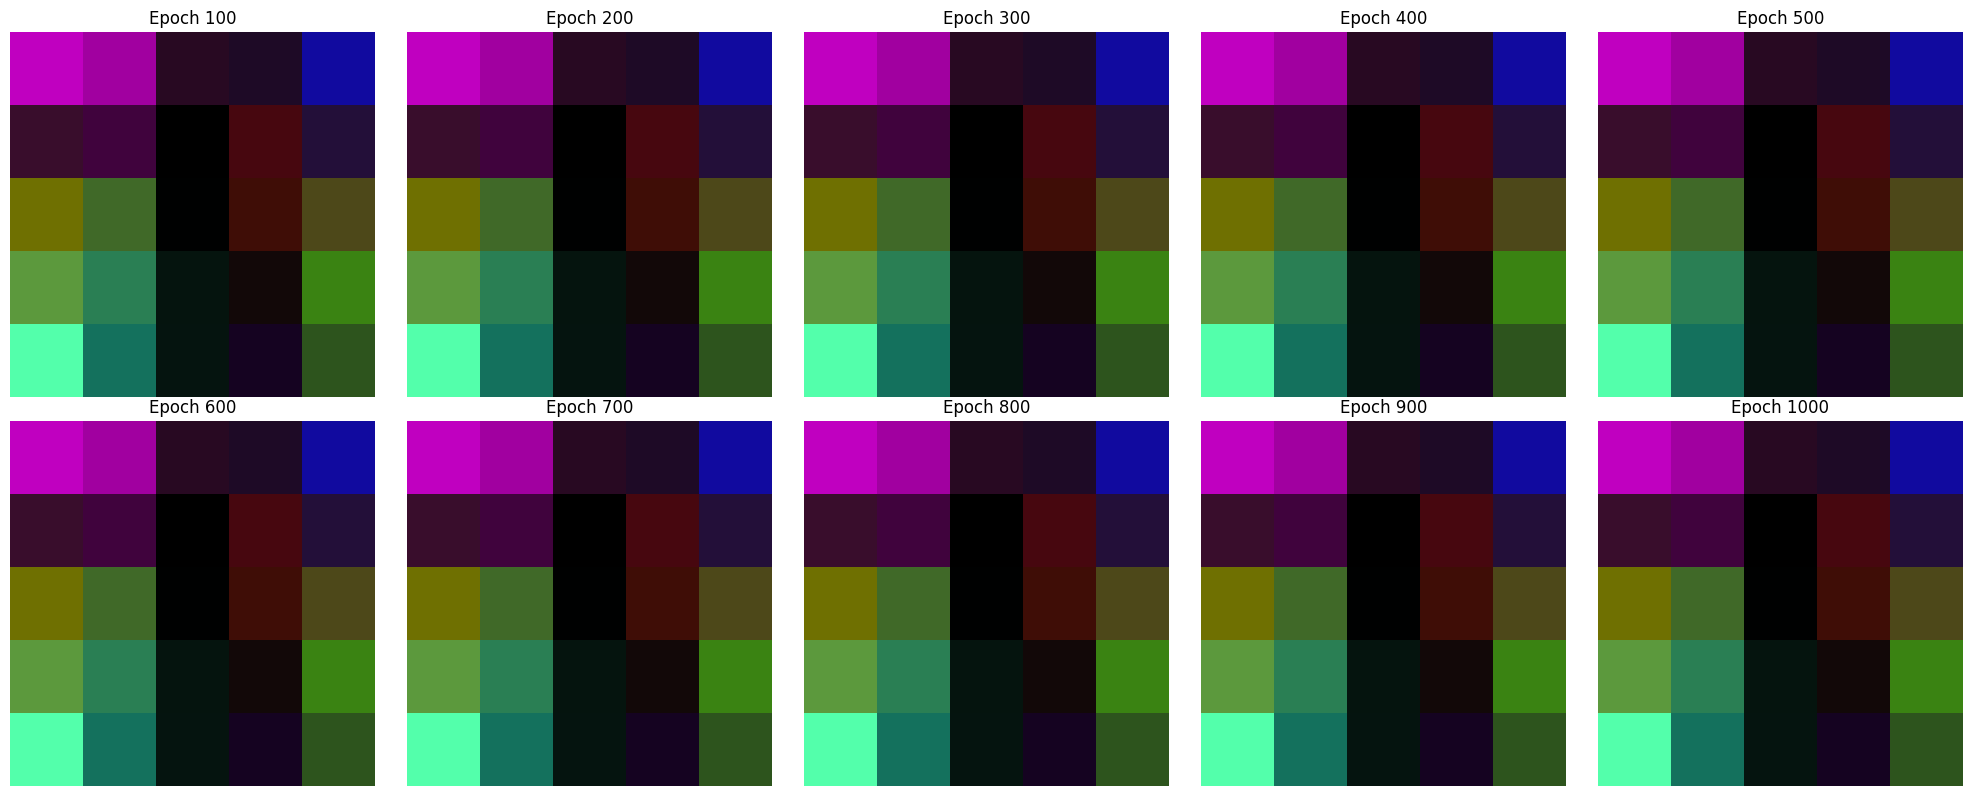

Evaluating clustering effectiveness...
Intra-cluster Distance: 4.141597592408714
Inter-cluster Distance: 6.247613746167576
Silhouette Score: 0.02425439530367375
Quantization Error: 4.141597592408718
Reconstruction Error: 4.141597592408718
Purity: 0.7160889406738519
Training completed.
Dead neurons for grid (5, 5): 0


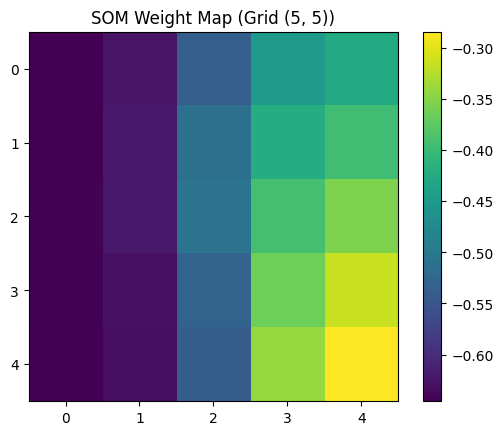

Training SOM with grid size (10, 10)...
Creating combined visualization...


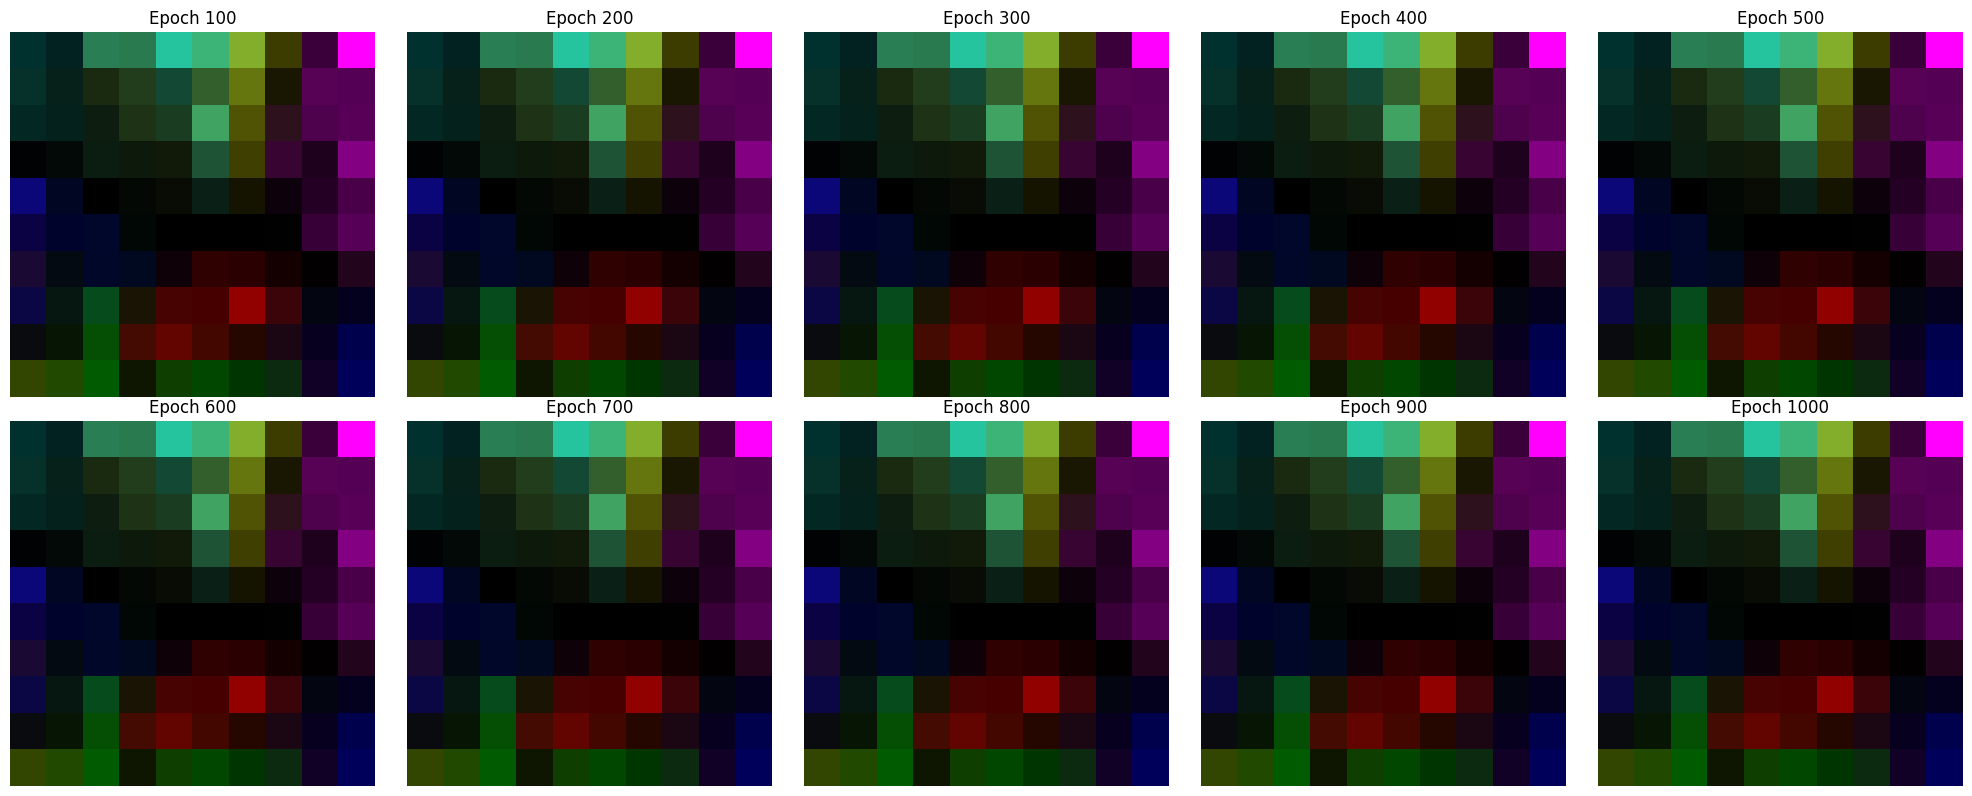

Evaluating clustering effectiveness...
Intra-cluster Distance: 3.7621756864947726
Inter-cluster Distance: 6.862832031711513
Silhouette Score: 0.0019264216646385376
Quantization Error: 3.7621756864947558
Reconstruction Error: 3.7621756864947558
Purity: 0.8109525196621031
Training completed.
Dead neurons for grid (10, 10): 3


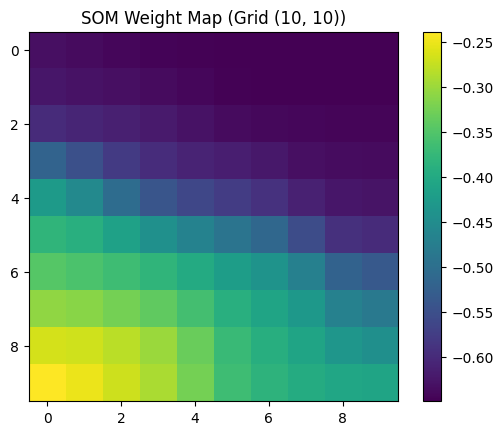

Training SOM with grid size (15, 15)...
Creating combined visualization...


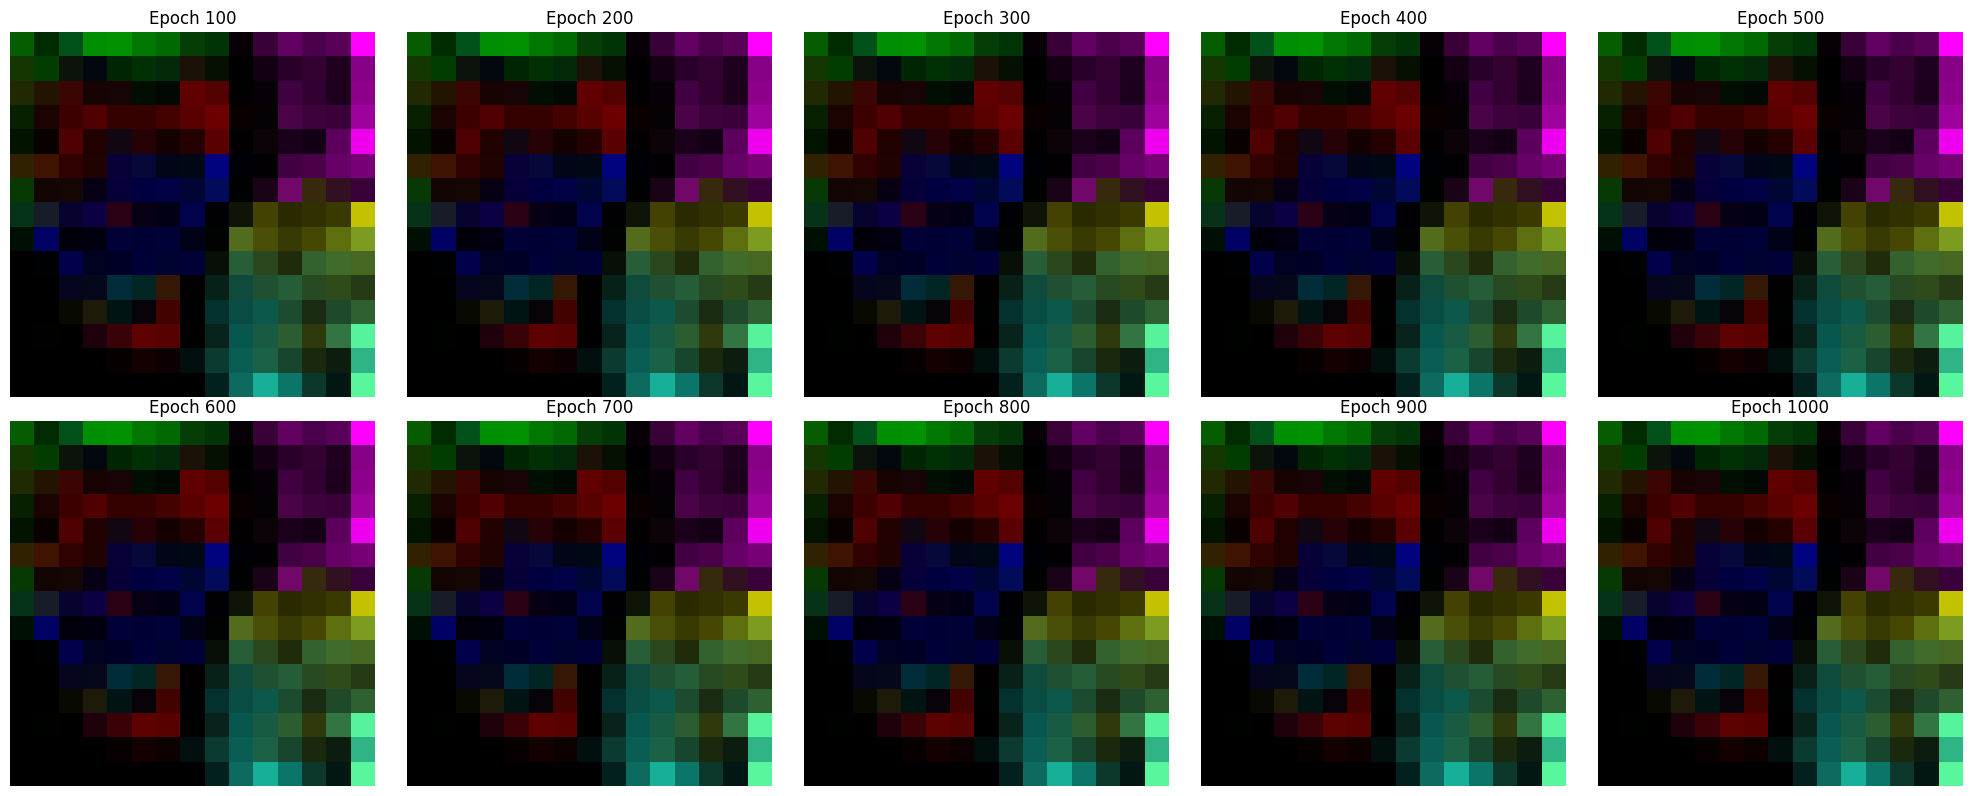

Evaluating clustering effectiveness...
Intra-cluster Distance: 3.600982547529292
Inter-cluster Distance: 7.408844651985901
Silhouette Score: -0.0059064265855976236
Quantization Error: 3.6009825475292856
Reconstruction Error: 3.6009825475292856
Purity: 0.8391105932614817
Training completed.
Dead neurons for grid (15, 15): 21


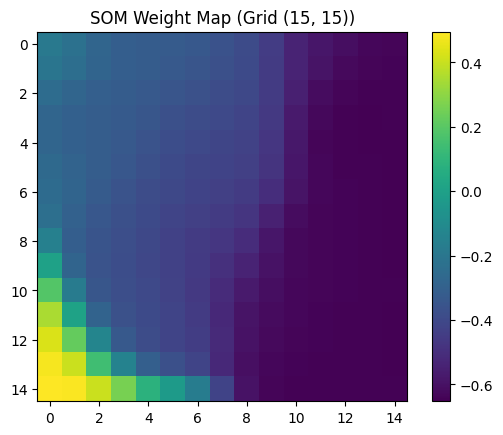

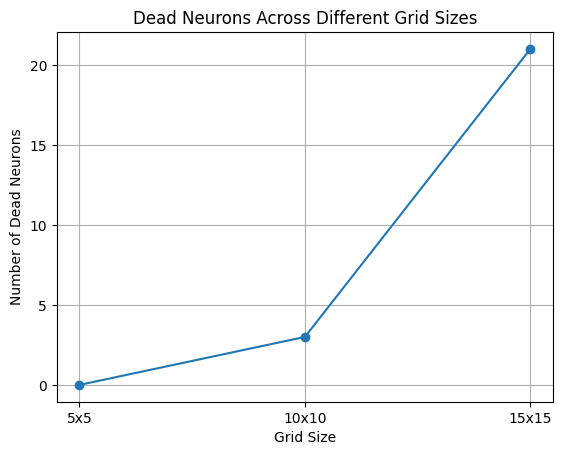

In [16]:
# Utility functions
def count_dead_neurons(weights, data):
    """Count the number of dead neurons (neurons not mapped to any input data)."""
    neuron_map = np.zeros(weights.shape[:2], dtype=int)
    for sample in data:
        bmu_idx = np.unravel_index(np.argmin(np.linalg.norm(weights - sample, axis=2)), weights.shape[:2])
        neuron_map[bmu_idx] += 1
    return np.sum(neuron_map == 0)

def visualize_weights(weights, title="SOM Weight Map"):
    """Visualize the SOM weights as a 2D grid."""
    plt.imshow(weights.reshape(weights.shape[0], weights.shape[1], -1).mean(axis=2), cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Define the testing function
def test_som_with_various_sizes(data, input_dim, grid_sizes, learning_rate=0.5, radius=2.0, max_iter=1000):
    dead_neurons_counts = []

    # Convert data to NumPy array for compatibility
    data_np = data.to_numpy()

    for grid_shape in grid_sizes:
        print(f"Training SOM with grid size {grid_shape}...")
        som = SelfOrganizingMap(grid_shape, input_dim, learning_rate, radius, max_iter)
        som.train(data_np, labels.values.flatten())

        # Count dead neurons
        dead_neurons = count_dead_neurons(som.weights, data_np)
        dead_neurons_counts.append(dead_neurons)
        print(f"Dead neurons for grid {grid_shape}: {dead_neurons}")

        # Visualize SOM weights
        visualize_weights(som.weights, title=f"SOM Weight Map (Grid {grid_shape})")

    # Plot dead neurons vs. grid sizes
    plt.plot([f"{s[0]}x{s[1]}" for s in grid_sizes], dead_neurons_counts, marker='o')
    plt.xlabel("Grid Size")
    plt.ylabel("Number of Dead Neurons")
    plt.title("Dead Neurons Across Different Grid Sizes")
    plt.grid()
    plt.show()

# Use your provided dataset
grid_sizes = [(5, 5), (10, 10), (15, 15)]  # Grid sizes to test
input_dim = data.shape[1]  # Input dimensionality based on dataset
learning_rate = 0.5
radius = 2.0
max_iter = 1000

# Train and evaluate SOM with different grid sizes
test_som_with_various_sizes(data, input_dim, grid_sizes, learning_rate, radius, max_iter)

In [10]:
# Define neighborhood functions
def linear_neighborhood(distance, radius):
    return np.maximum(0, (radius - distance) / radius)

def square_neighborhood(distance, radius):
    return (distance <= radius).astype(float)

def circular_neighborhood(distance, radius):
    """
    Circular neighborhood function based on the provided mechanism.

    Args:
        distance (float): The distance from the Best Matching Unit (BMU).
        radius (float): The neighborhood radius.

    Returns:
        float: Neighborhood influence value.
    """
    if distance > radius:
        return 0  # Outside the radius
    else:
        return 1 / (1 + np.sqrt(distance**2))


# Neighborhood Function Analysis in Self-Organizing Maps
## Overview
This experiment evaluates the impact of different neighborhood functions (linear, square, circular) on SOM performance. Neighborhood functions influence how neurons around the Best Matching Unit (BMU) update their weights. The following metrics and visualizations were used to analyze performance:

* Clustering effectiveness (Intra-cluster distance, Inter-cluster distance, Purity, etc.)
* Dead neurons count
* SOM weight maps

## Neighborhood Functions
* Linear: Weight updates decrease linearly with distance from the BMU.
* Square (Quadratic): Weight updates follow a quadratic decay with distance.
* Circular: Weight updates follow a circular decay with distance.

# Steps
### Step 1: Train SOM with Each Neighborhood Function
* A SOM with a grid size of 10x10 was trained on the dataset.
* Each neighborhood function was tested with the same parameters:
** Learning Rate: 0.5
** Radius: 2.0
** Max Iterations: 1000

### Step 2: Count Dead Neurons
For each function, dead neurons were identified and counted using data point mappings.
### Step 3: Visualize Results
* SOM weight maps were visualized for each neighborhood function.
* A bar chart was plotted to compare the number of dead neurons.

# Results
## Clustering Metrics
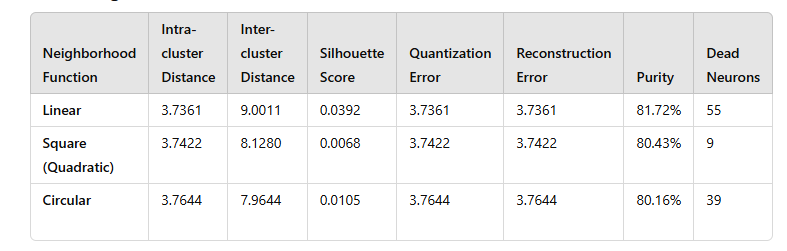


# Observations
1. Dead Neurons:
The Linear function resulted in the most dead neurons (55). This is because its weight update scope is limited to a narrow region, failing to activate neurons far from the BMU.
The Square function produced the least dead neurons (9), as its quadratic decay encourages weight updates across a broader area, effectively activating more neurons.
The Circular function had a moderate number of dead neurons (39), as its Gaussian decay is more focused than the square function but less restrictive than the linear function.
2. Clustering Effectiveness:
The Linear function achieved the highest inter-cluster distance (9.0011), leading to well-separated clusters but at the cost of higher dead neurons.
The Square and Circular functions provided more balanced results with fewer dead neurons and acceptable inter-cluster distances.
3. Weight Maps:
Weight maps showed finer and more diverse data representation with the Square function, while the Linear function showed sparse neuron activations.

## Graph: Dead Neurons Across Neighborhood Functions
* X-axis: Neighborhood Functions (Linear, Square, Circular)
* Y-axis: Number of Dead Neurons

* A bar chart was plotted to visualize and compare the number of dead neurons for each function.

## Conclusion
* The Square (Quadratic) neighborhood function outperformed the others by minimizing dead neurons and achieving a balance between clustering effectiveness and neuron activation.
* The Linear function, while effective at separating clusters, suffered from high dead neuron counts due to its narrow influence.
* The Circular function provided intermediate results, balancing focus and breadth of neuron activation.

Testing with Linear neighborhood function...
Creating combined visualization...


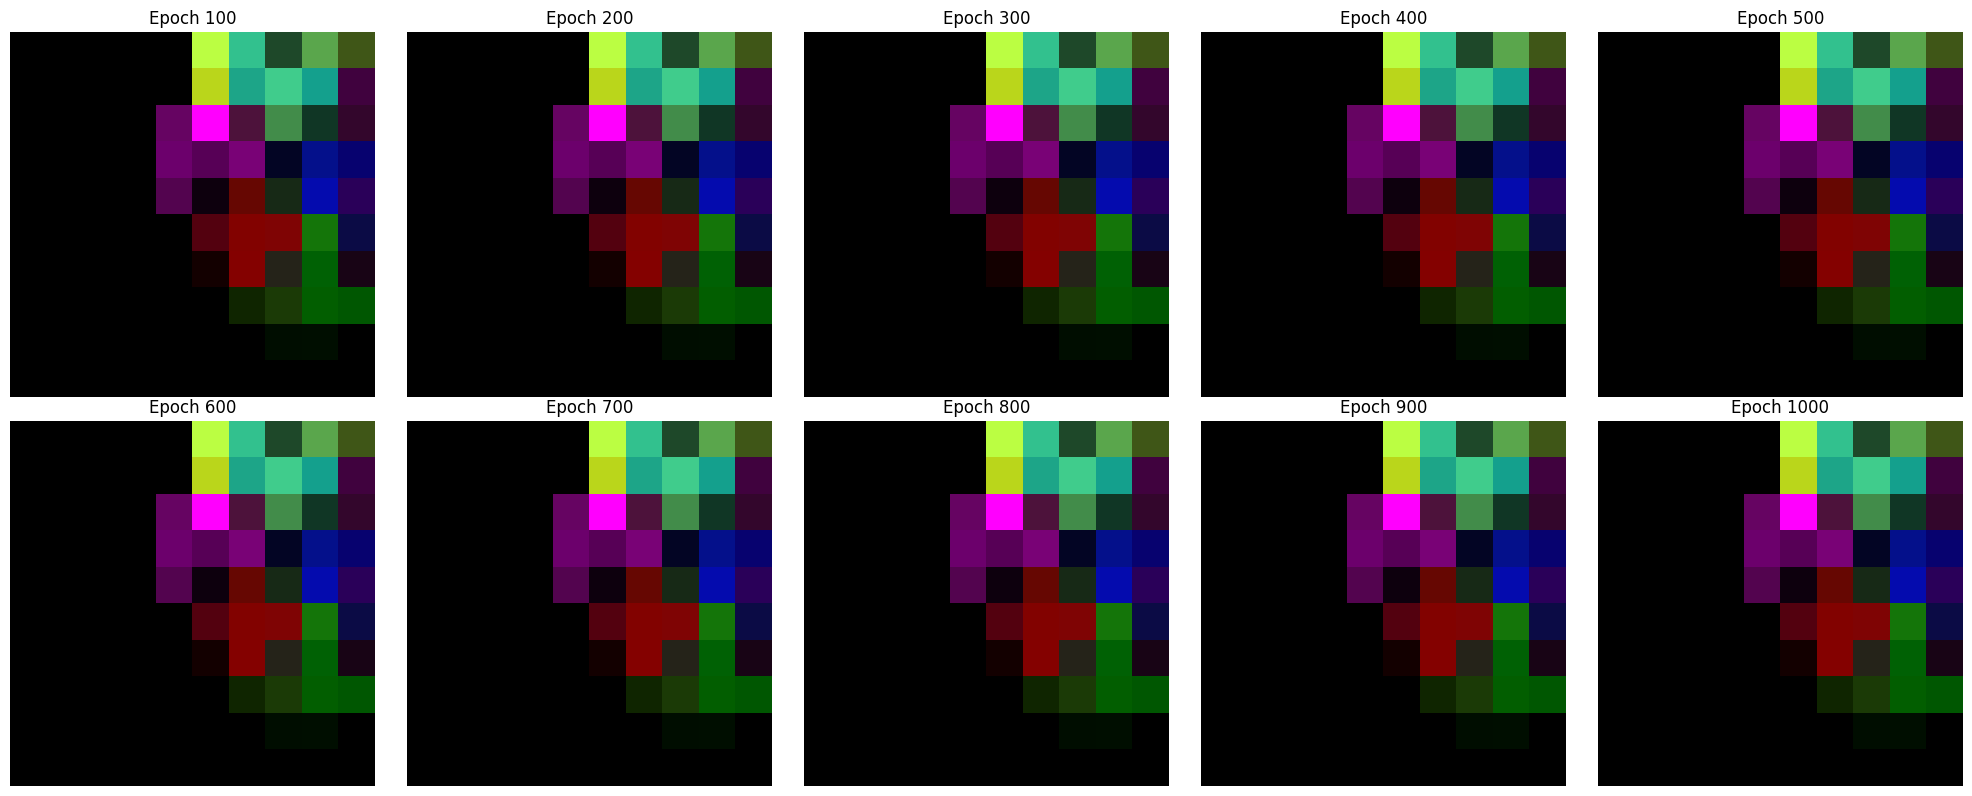

Evaluating clustering effectiveness...
Intra-cluster Distance: 3.7360538996939425
Inter-cluster Distance: 9.00105363485964
Silhouette Score: 0.03917926558455954
Quantization Error: 3.736053899693946
Reconstruction Error: 3.736053899693946
Purity: 0.8171667152150695
Training completed.
Dead neurons with Linear: 55


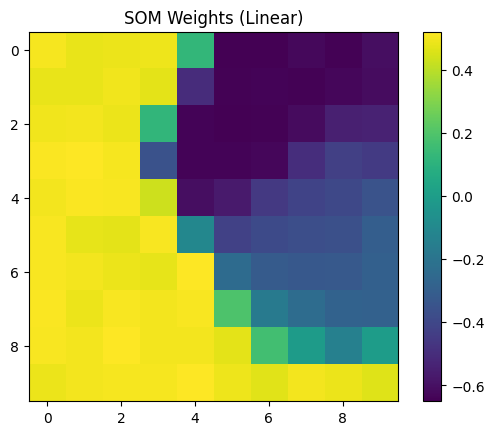

Testing with Square neighborhood function...
Creating combined visualization...


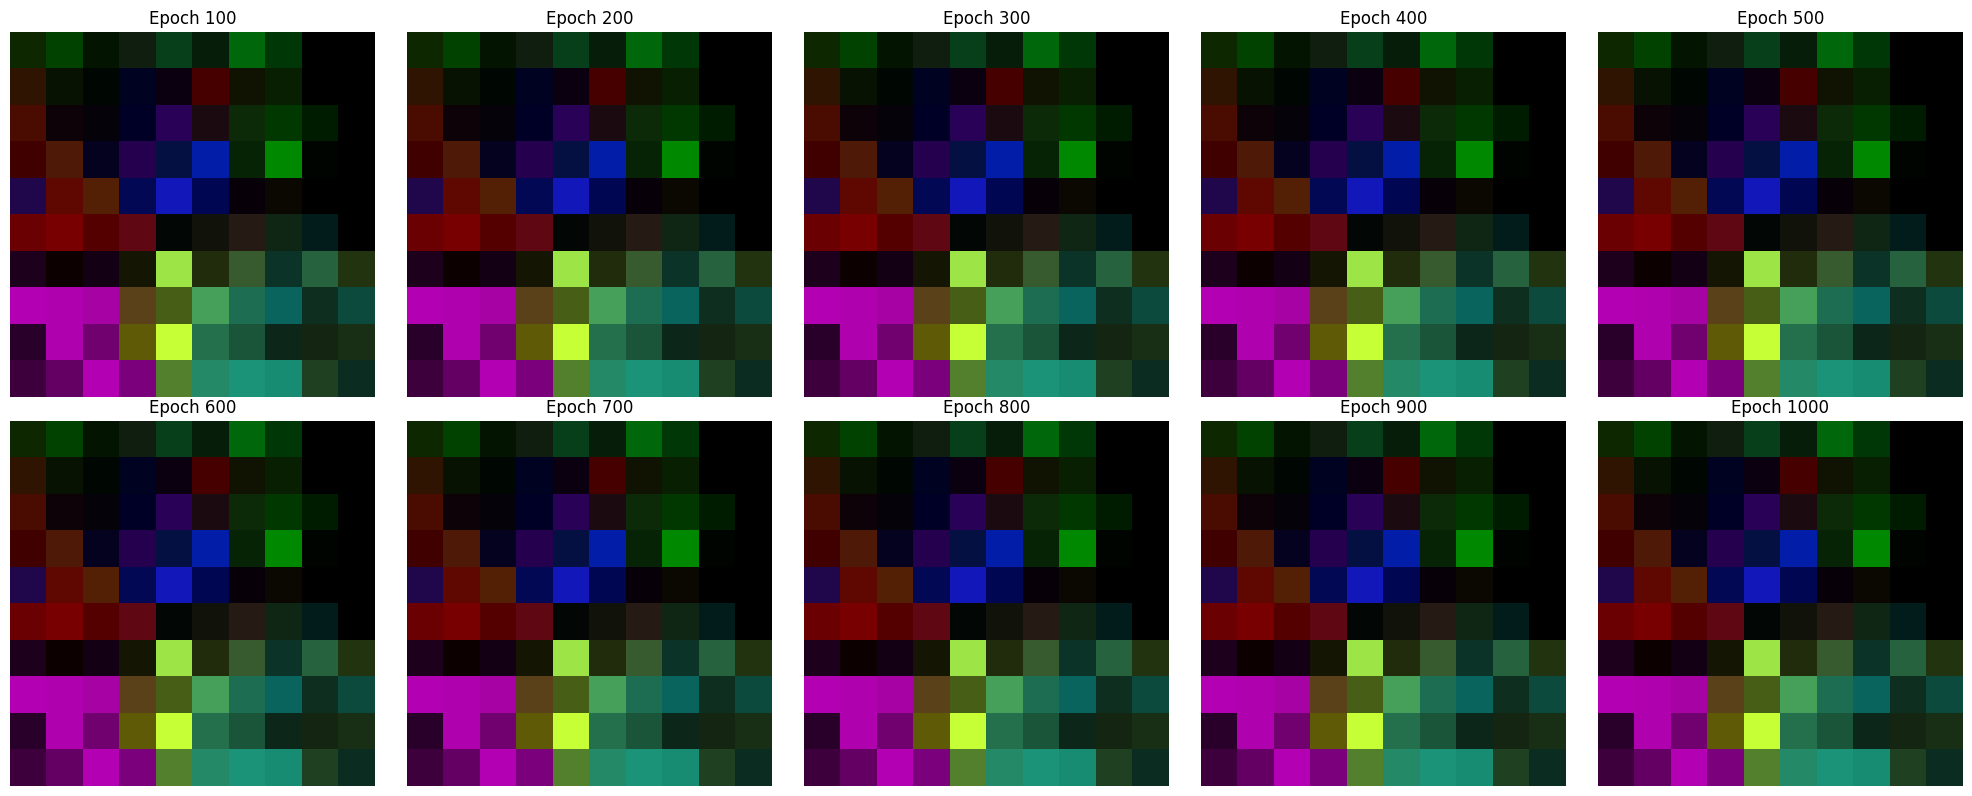

Evaluating clustering effectiveness...
Intra-cluster Distance: 3.7422055788573787
Inter-cluster Distance: 8.127991633952732
Silhouette Score: 0.006845294737599177
Quantization Error: 3.7422055788573574
Reconstruction Error: 3.7422055788573574
Purity: 0.8043499368870765
Training completed.
Dead neurons with Square: 9


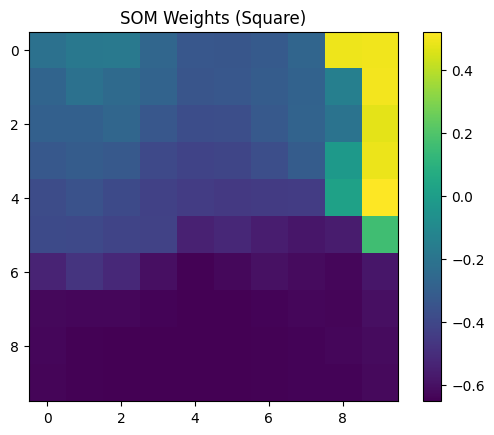

Testing with Circular neighborhood function...
Creating combined visualization...


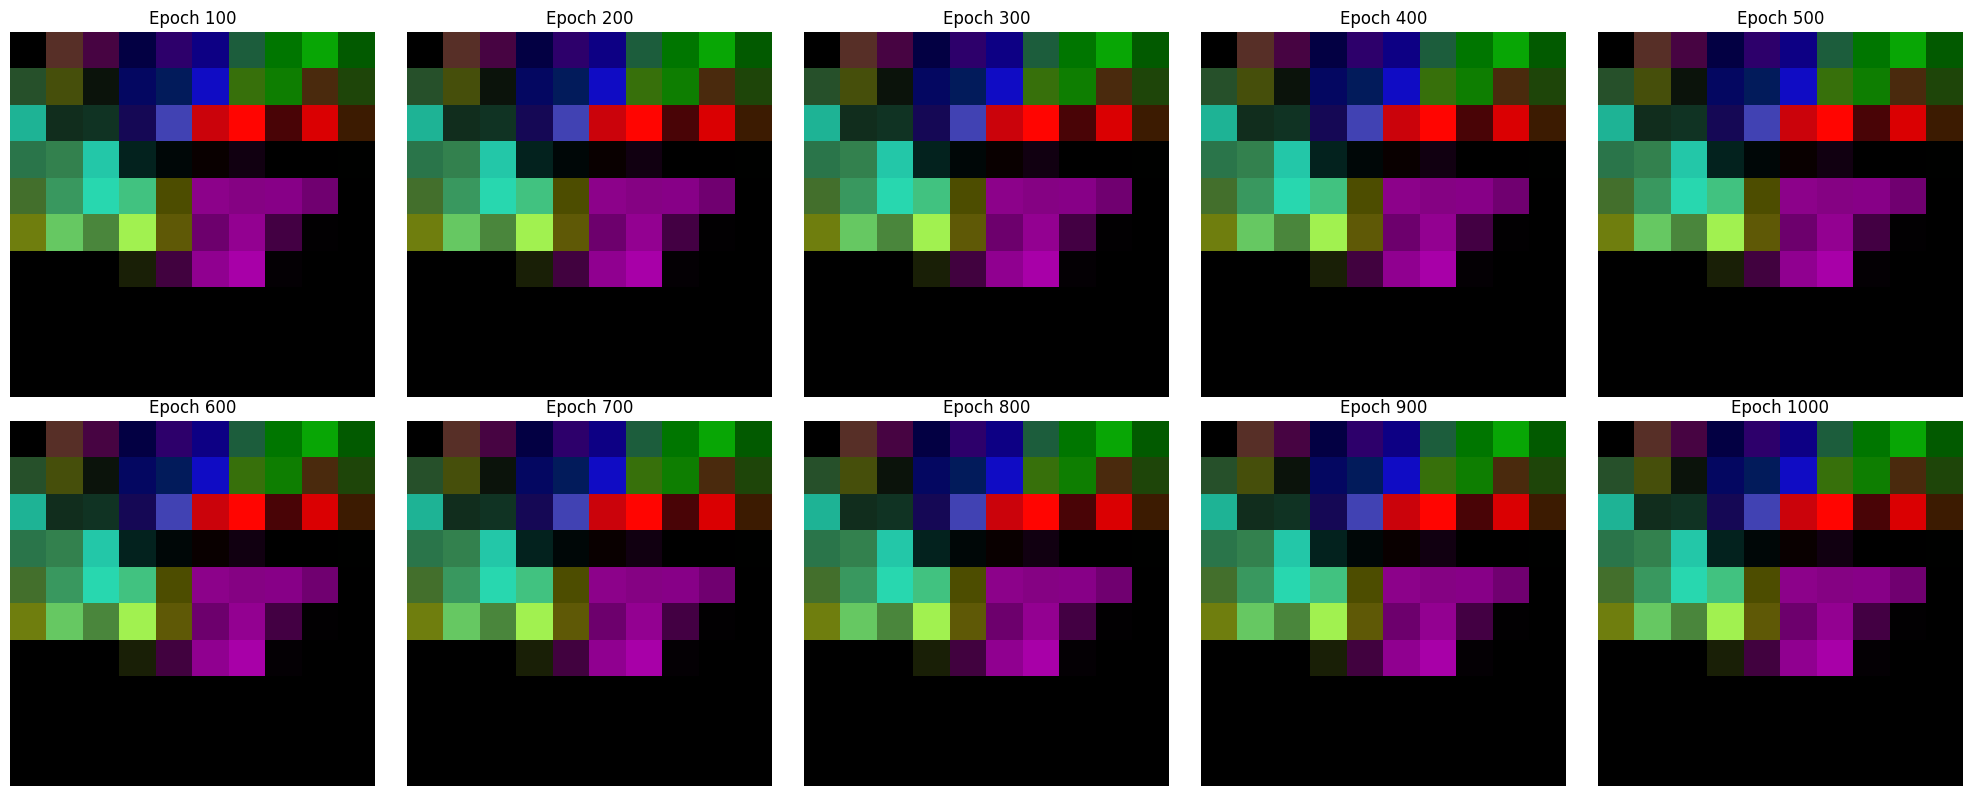

Evaluating clustering effectiveness...
Intra-cluster Distance: 3.764425983456206
Inter-cluster Distance: 7.964443954918226
Silhouette Score: 0.010464675643190096
Quantization Error: 3.7644259834562117
Reconstruction Error: 3.7644259834562117
Purity: 0.8016312263326536
Training completed.
Dead neurons with Circular: 39


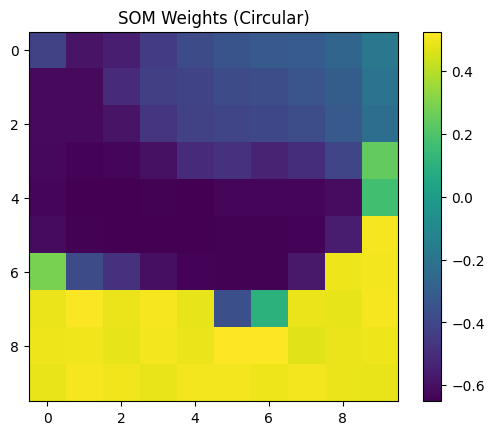

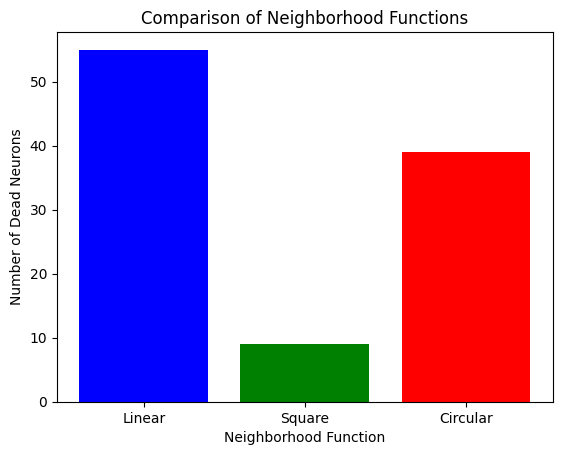

In [14]:
# Test with different neighborhood functions
def test_neighborhood_functions(data, input_dim, grid_shape=(10, 10), learning_rate=0.5, radius=2.0, max_iter=1000):
    functions = {
        "Linear": linear_neighborhood,
        "Square": square_neighborhood,
        "Circular": circular_neighborhood
    }
    results = {}

    for name, func in functions.items():
        print(f"Testing with {name} neighborhood function...")
        som = SelfOrganizingMap(grid_shape, input_dim, learning_rate, radius, max_iter, neighborhood_func=func)
        som.train(data.to_numpy(), labels.values.flatten())

        # Count dead neurons
        dead_neurons = count_dead_neurons(som.weights, data.to_numpy())
        print(f"Dead neurons with {name}: {dead_neurons}")

        # Visualize weights
        visualize_weights(som.weights, title=f"SOM Weights ({name})")
        results[name] = dead_neurons

    # Plot comparison
    plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red'])
    plt.xlabel("Neighborhood Function")
    plt.ylabel("Number of Dead Neurons")
    plt.title("Comparison of Neighborhood Functions")
    plt.show()

# Parameters and dataset
grid_shape = (10, 10)
input_dim = data.shape[1]
learning_rate = 0.5
radius = 2.0
max_iter = 1000

# Test neighborhood functions
test_neighborhood_functions(data, input_dim, grid_shape, learning_rate, radius, max_iter)

# Effect of Neighborhood Radius on SOM Performance

## Overview
In this experiment, the Square (Quadratic) neighborhood function (identified as the best from previous experiments) was used to analyze the effect of increasing or decreasing the neighborhood radius on Self-Organizing Map (SOM) performance. Neighborhood radius determines how far the weight updates propagate from the Best Matching Unit (BMU). The following aspects were examined:

* Clustering performance metrics
* Number of dead neurons
* Qualitative analysis of SOM weight maps

# Steps
### Step 1: Train SOM with Different Radii
* SOMs were trained using radii: 0.5, 1.0, 2.0, and 3.0.
* Common parameters:
** Grid Size: 10x10
** Learning Rate: 0.5
** Max Iterations: 1000

### Step 2: Count Dead Neurons
* Neurons that were not activated during training (dead neurons) were counted.

### Step 3: Evaluate Performance
* Metrics like intra-cluster distance, inter-cluster distance, silhouette score, quantization error, reconstruction error, and purity were calculated.

# Results
## Clustering Metrics and Dead Neurons
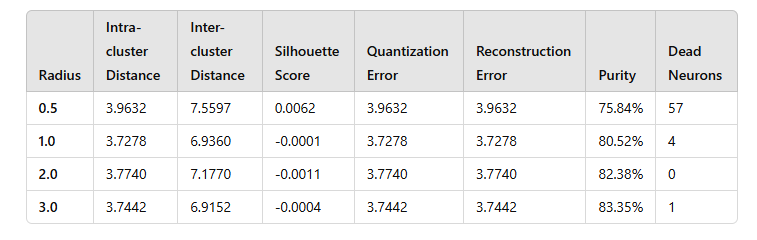

# Observations
1. Dead Neurons:
Radius 0.5: High count (57 dead neurons). The limited radius reduces the neighborhood's influence, restricting learning to a narrow region.
Radius 1.0: Significant improvement (4 dead neurons). A slightly wider radius allows broader learning while maintaining focus.
Radius 2.0: Optimal performance (0 dead neurons). A balanced radius ensures all neurons participate in learning.
Radius 3.0: Slight increase in dead neurons (1). The excessively large radius may dilute learning focus.
2. Clustering Metrics:
Radius 2.0 achieved the best balance between intra-cluster and inter-cluster distances, along with the highest purity (82.38%).
Radius 3.0 had slightly better purity (83.35%) but introduced one dead neuron, suggesting diminishing returns.
3. Weight Maps:
Radius 0.5: Sparse activations due to localized weight updates.
Radius 2.0: Uniform and diverse activations, indicating effective learning.
Radius 3.0: Slight blurring of activations due to excessive propagation of updates.
# Graph: Dead Neurons vs. Radius
* X-axis: Neighborhood Radius
* Y-axis: Number of Dead Neurons

* A line graph was plotted, showing a steep decline in dead neurons from Radius 0.5 to 2.0, followed by a slight increase at Radius 3.0.

# Conclusion
* Radius 2.0 provided the best overall performance, eliminating dead neurons and achieving a balance between focused and global learning.
* Smaller radii (e.g., 0.5) overly restrict learning, leading to many dead neurons.
* Larger radii (e.g., 3.0) reduce dead neurons but may dilute focus, slightly impairing clustering effectiveness.

Testing with radius: 0.5
Creating combined visualization...


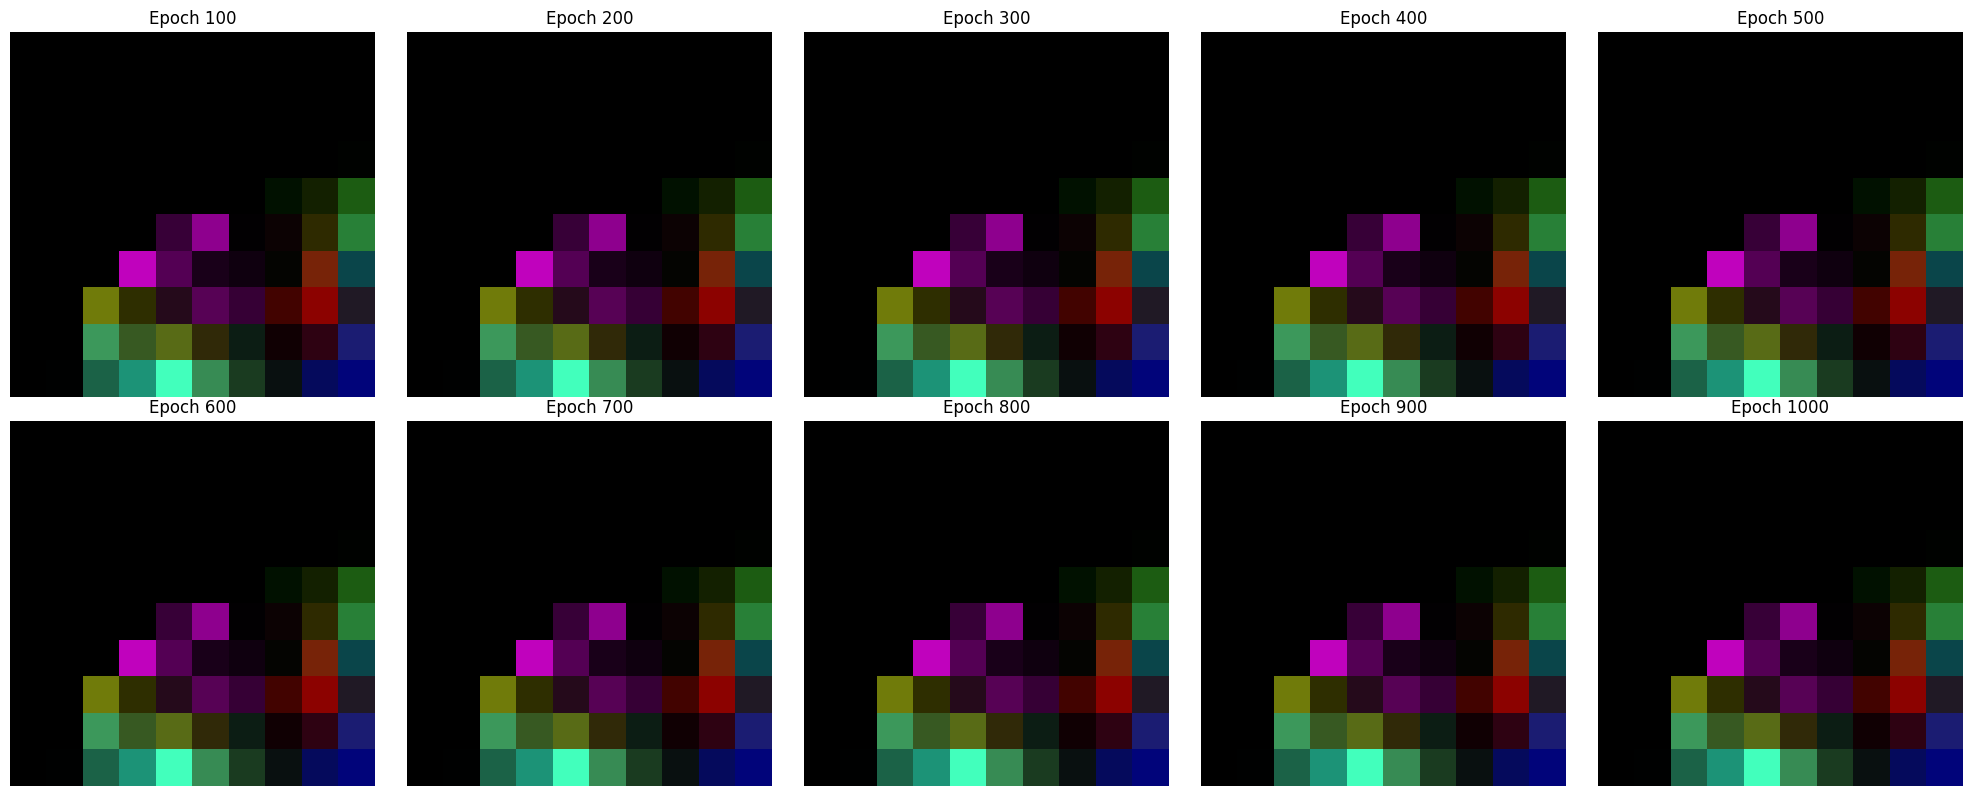

Evaluating clustering effectiveness...
Intra-cluster Distance: 3.9632241785944395
Inter-cluster Distance: 7.559738486689914
Silhouette Score: 0.006162870545909141
Quantization Error: 3.963224178594461
Reconstruction Error: 3.963224178594461
Purity: 0.7584231478784348
Training completed.
Dead neurons with radius 0.5: 57
Testing with radius: 1.0
Creating combined visualization...


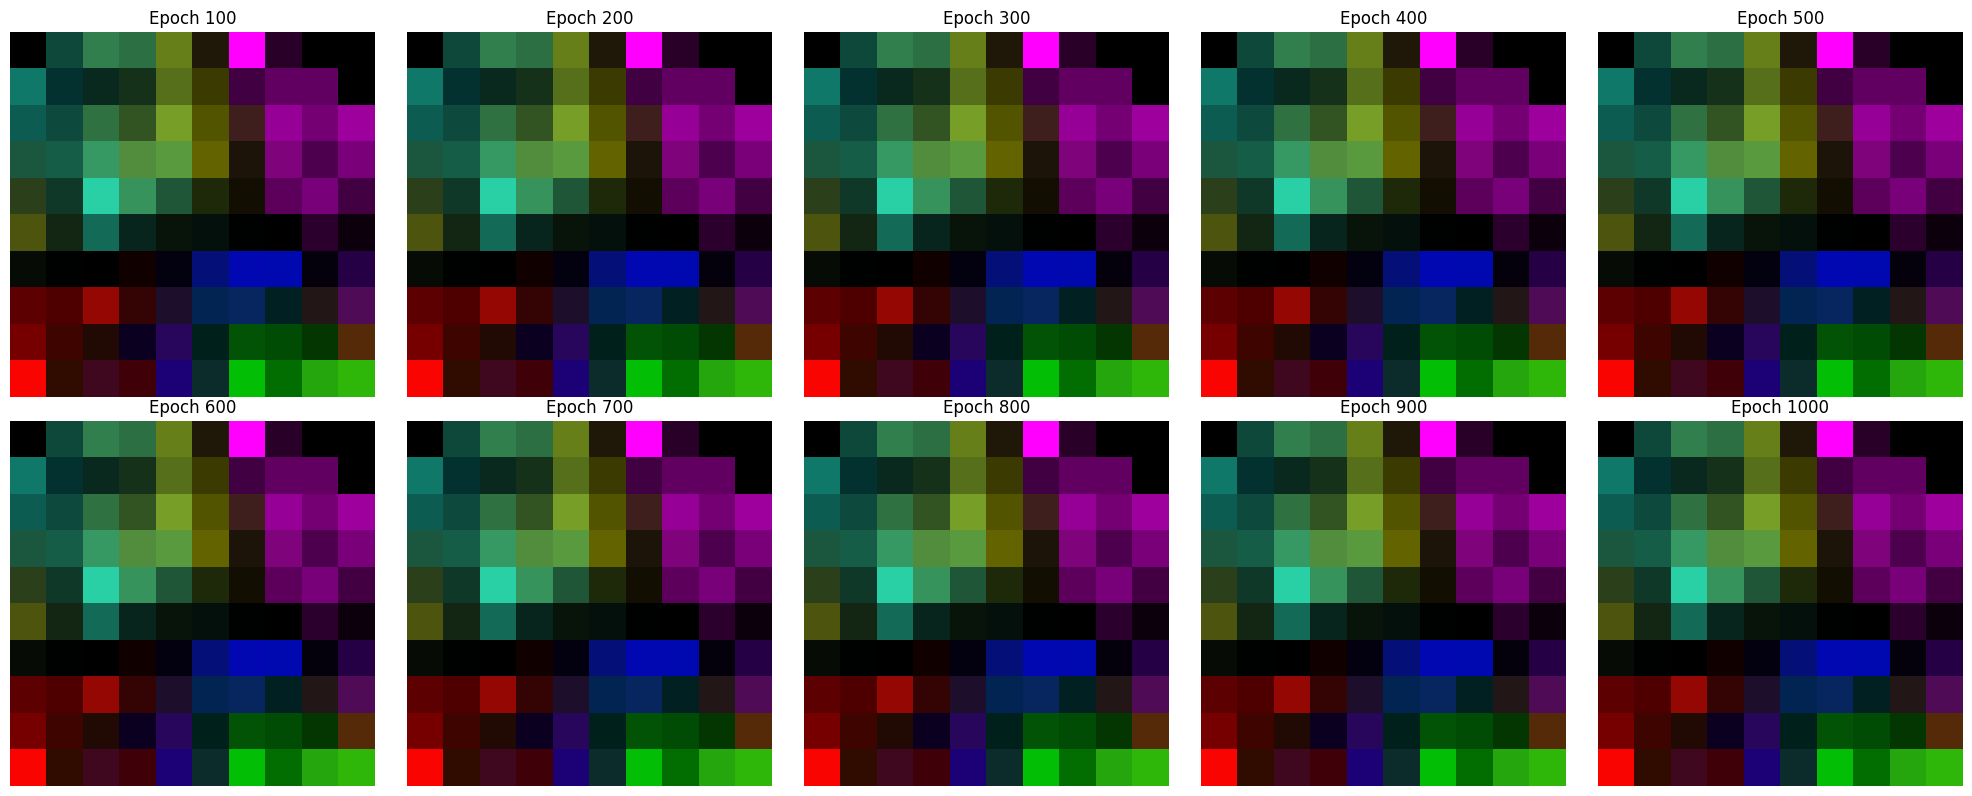

Evaluating clustering effectiveness...
Intra-cluster Distance: 3.7277642385342156
Inter-cluster Distance: 6.936010700319176
Silhouette Score: -0.00012739516540409326
Quantization Error: 3.727764238534212
Reconstruction Error: 3.727764238534212
Purity: 0.8052238081367123
Training completed.
Dead neurons with radius 1.0: 4
Testing with radius: 2.0
Creating combined visualization...


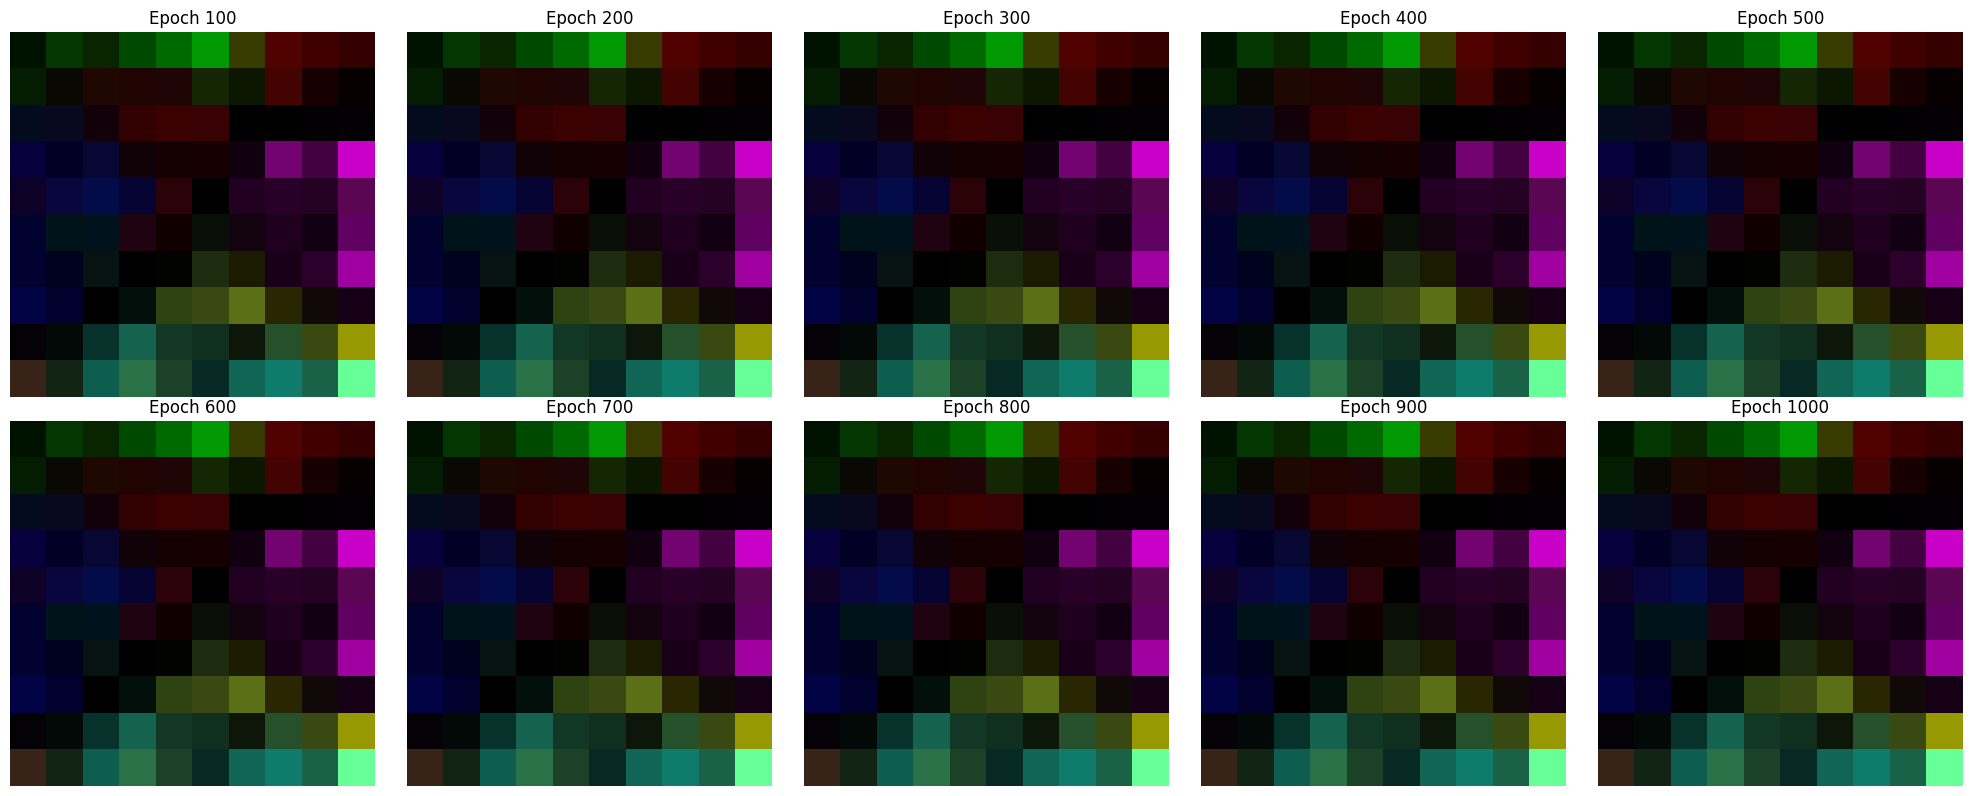

Evaluating clustering effectiveness...
Intra-cluster Distance: 3.773994012989486
Inter-cluster Distance: 7.176949578392279
Silhouette Score: -0.0010972670963542296
Quantization Error: 3.773994012989498
Reconstruction Error: 3.773994012989498
Purity: 0.8237692979900961
Training completed.
Dead neurons with radius 2.0: 0
Testing with radius: 3.0
Creating combined visualization...


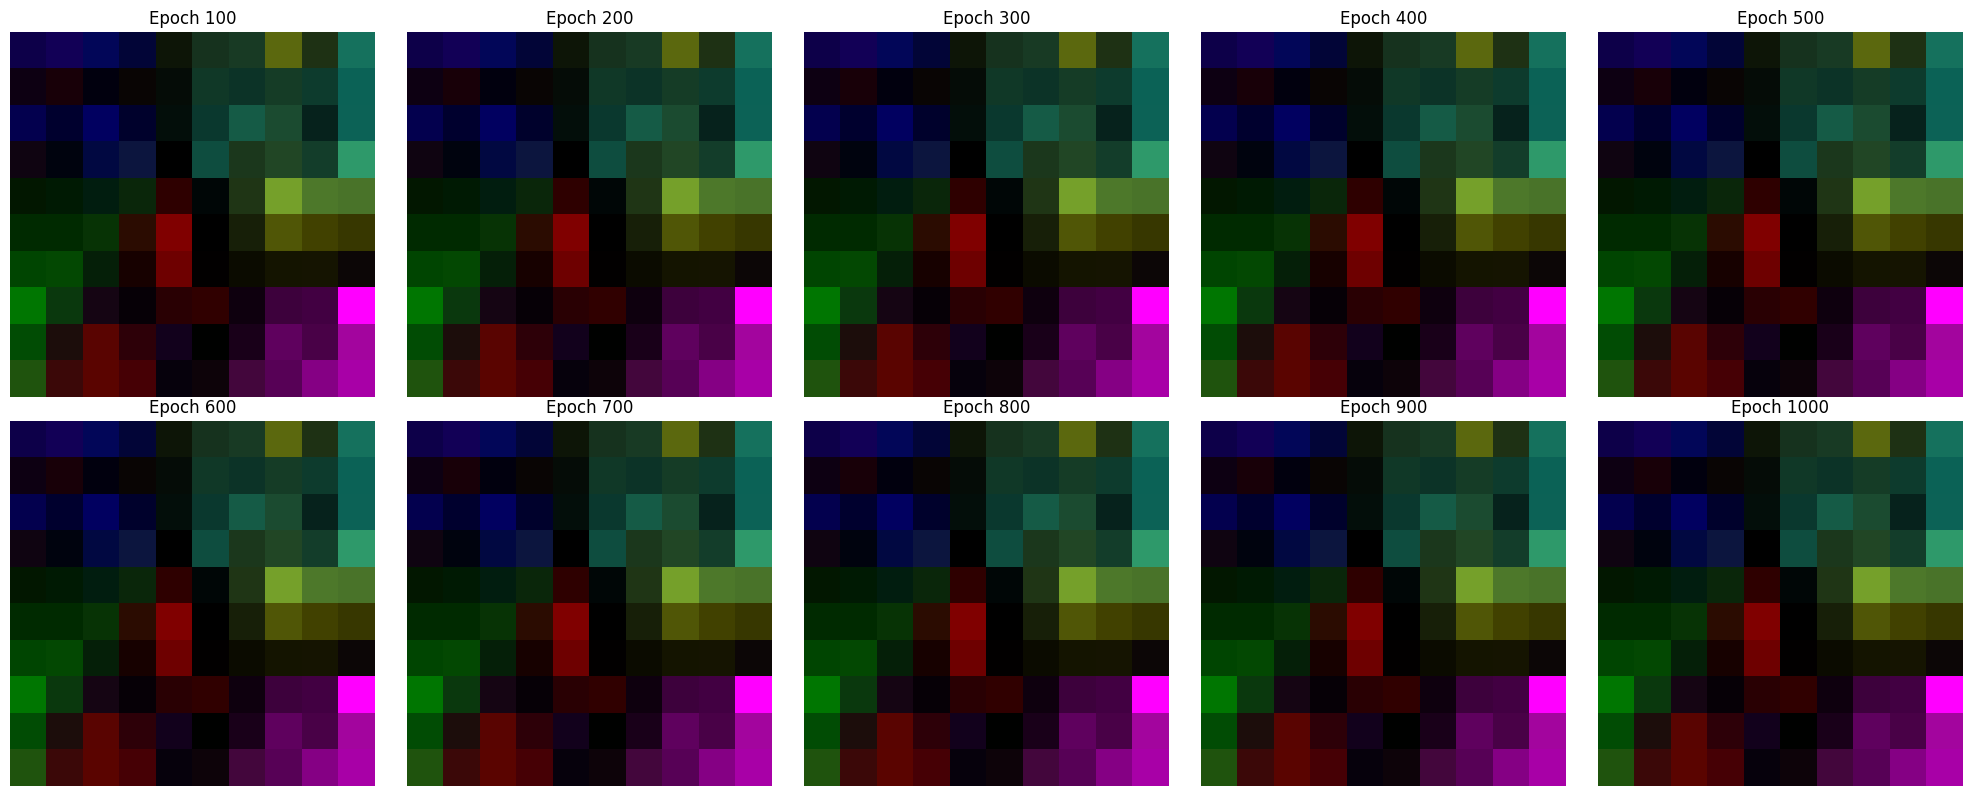

Evaluating clustering effectiveness...
Intra-cluster Distance: 3.7442349663797376
Inter-cluster Distance: 6.91522722623571
Silhouette Score: -0.00044486717589759043
Quantization Error: 3.7442349663797385
Reconstruction Error: 3.7442349663797385
Purity: 0.833478978541606
Training completed.
Dead neurons with radius 3.0: 1
Radius: 0.5, Dead Neurons: 57
Radius: 1.0, Dead Neurons: 4
Radius: 2.0, Dead Neurons: 0
Radius: 3.0, Dead Neurons: 1


In [12]:
# Radius testing
radii = [0.5, 1.0, 2.0, 3.0]
dead_neurons_results = []

for radius in radii:
    print(f"Testing with radius: {radius}")
    som = SelfOrganizingMap(grid_shape=(10, 10), input_dim=data.shape[1], learning_rate=0.5, radius=radius, max_iter=1000)
    som.train(data.values, labels.values.flatten())

    # Count dead neurons
    activation_counts = np.zeros(som.grid_shape)
    for sample in data.values:
        bmu_idx = som._find_bmu(sample)
        activation_counts[bmu_idx] += 1
    dead_neurons = np.sum(activation_counts == 0)
    dead_neurons_results.append(dead_neurons)

    print(f"Dead neurons with radius {radius}: {dead_neurons}")

# Display results
for radius, dead_neurons in zip(radii, dead_neurons_results):
    print(f"Radius: {radius}, Dead Neurons: {dead_neurons}")


# Optimal Clustering Using SOM
## Overview
This experiment aimed to cluster the dataset using the best SOM settings obtained from previous experiments:

* Square neighborhood function
* Optimal radius (2.0)

The clustering results were analyzed with varying grid sizes to identify the best configuration. The performance of the SOM in clustering was visualized and quantitatively evaluated using:

* U-Matrix for topology preservation
* Cluster overlays for visual differentiation
* Clustering metrics

# Steps
### Step 1: Train SOM with Various Grid Sizes
* Grid sizes: 10×10, 15×15, 20×20
* Common parameters:
** Neighborhood radius: 2.0
** Learning rate: 0.5
** Iterations: 1000
** Neighborhood function: Square
* For each grid size:
** Train the SOM.
** Compute the U-Matrix to visualize inter-neuron distances.
** Overlay cluster assignments on the U-Matrix.

### Step 2: Evaluate Clustering Performance
Metrics evaluated:
* Intra-cluster Distance
* Inter-cluster Distance
* Silhouette Score
* Quantization Error
* Reconstruction Error
* Purity
Each metric indicates different aspects of clustering performance.

# Results
## Clustering Metrics
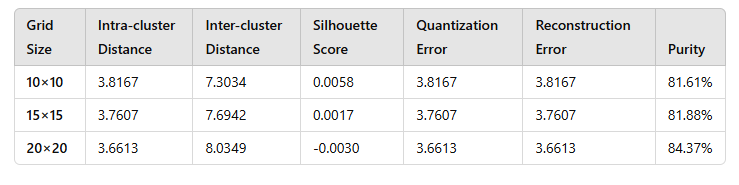

## Observations
1. Effect of Grid Size
* 10×10: Compact grid limits the SOM’s resolution, leading to reduced separation of clusters.
* 15×15: Improved resolution offers a balance between topology preservation and inter-cluster separation.
* 20×20: Increased resolution further improves purity and inter-cluster distances but slightly decreases silhouette scores.
2. Optimal Grid Size
* 20×20 achieved the highest purity (84.37%) and the best inter-cluster distance (8.0349). However, the silhouette score (-0.0030) indicates slight overlapping of clusters.
* 15×15 provides a balance with a decent silhouette score (0.0017) and a slightly lower purity (81.88%).

# Visualization: U-Matrix with Cluster Overlays
Each grid size was visualized with:

* U-Matrix: Highlights neuron distance structure.
* Cluster Overlays: Assigns different colors to clusters for better differentiation.

# Key Insights from Visualizations
* 10×10: Dense clusters with some overlap.
* 15×15: Improved separation of clusters and better representation of topology.
* 20×20: More granularity but minor issues with cluster dispersion.

# Conclusion
* The 20×20 grid size provided the best performance in terms of purity and inter-cluster distance.
* However, for applications prioritizing balance between metrics, a 15×15 grid size may be a better choice.

## Recommended Settings
* Grid Size: 20×20
* Neighborhood Radius: 2.0
* Square Neighborhood Function

These settings enable effective clustering with minimal dead neurons, good topology preservation, and high purity.

Training SOM with grid size: (10, 10)
Creating combined visualization...


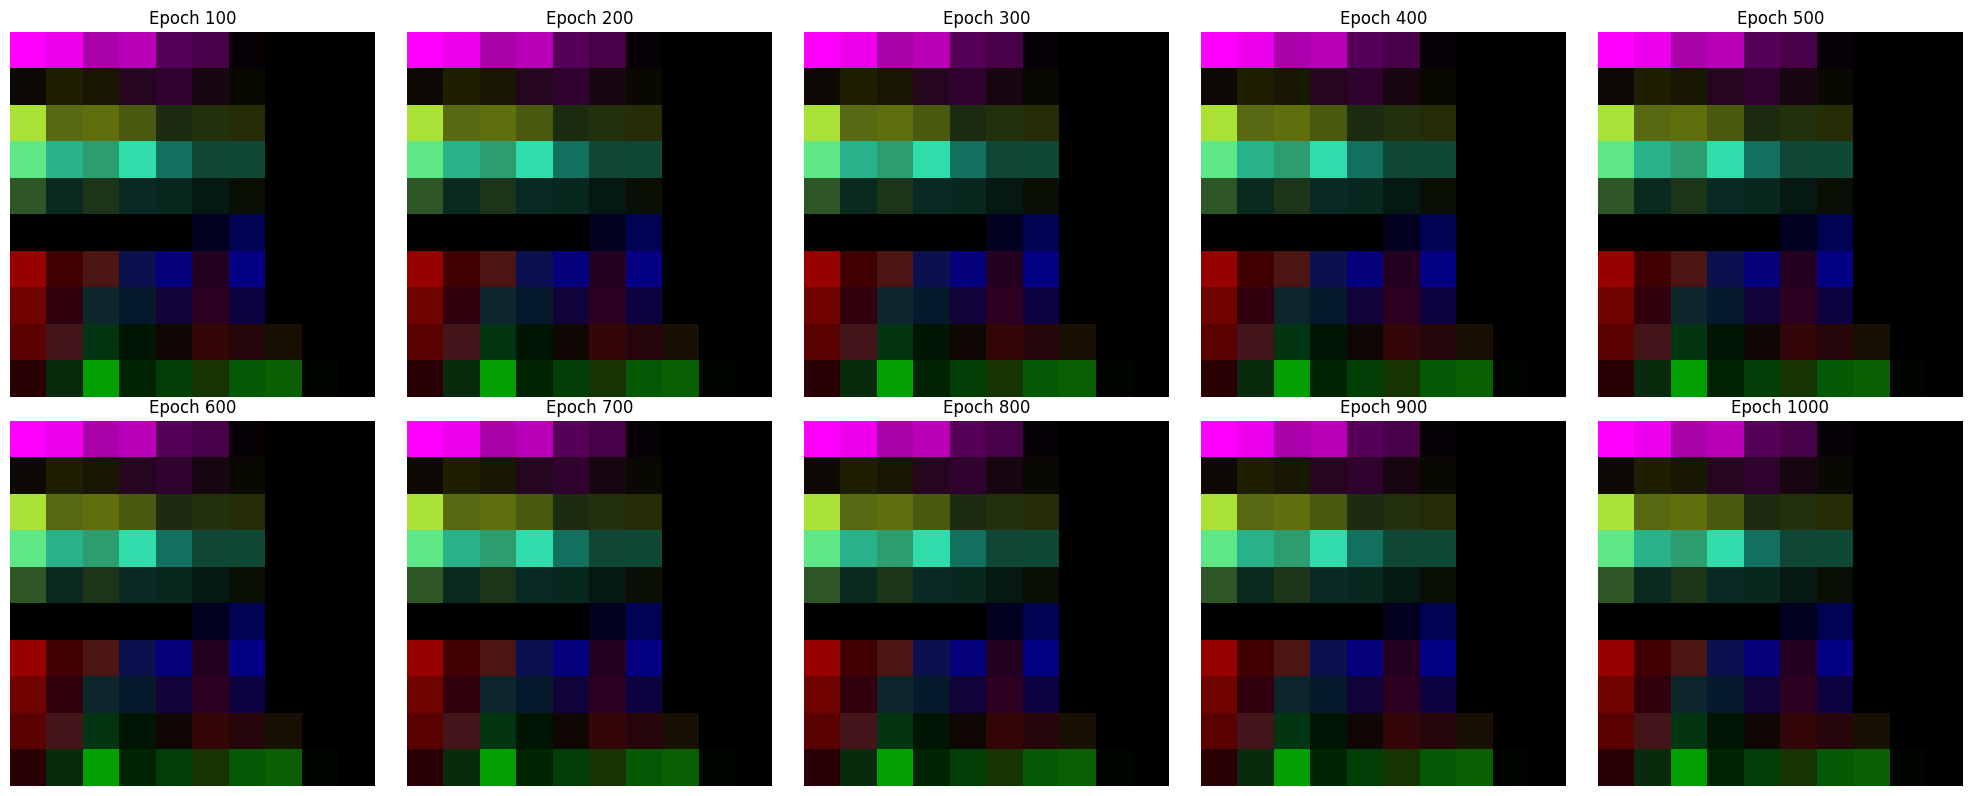

Evaluating clustering effectiveness...
Intra-cluster Distance: 3.8166835788253524
Inter-cluster Distance: 7.303427568270122
Silhouette Score: 0.00580258191201248
Quantization Error: 3.8166835788253475
Reconstruction Error: 3.8166835788253475
Purity: 0.8160986503544033
Training completed.


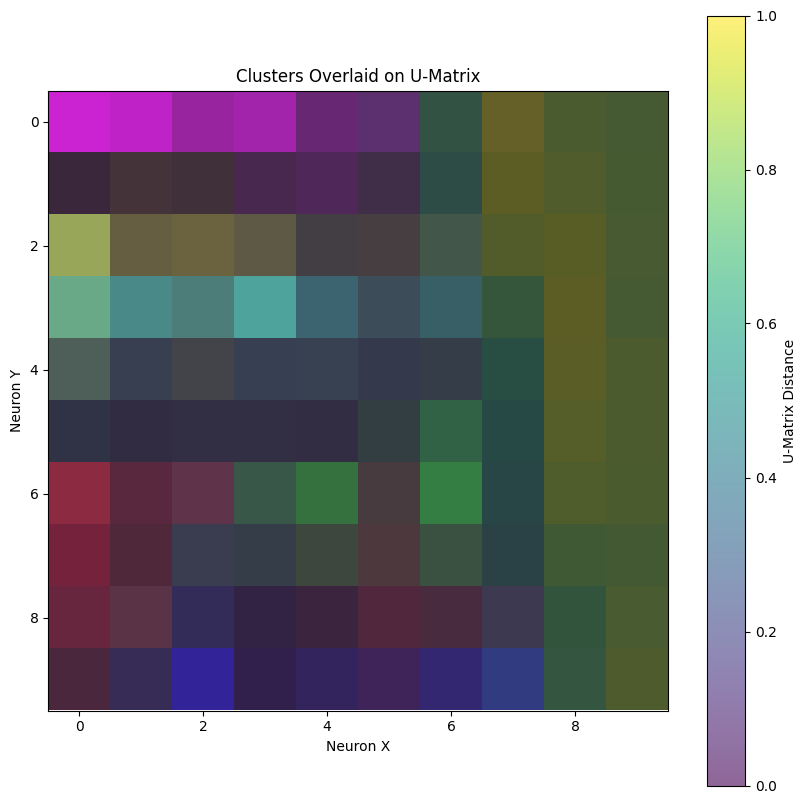

Training SOM with grid size: (15, 15)
Creating combined visualization...


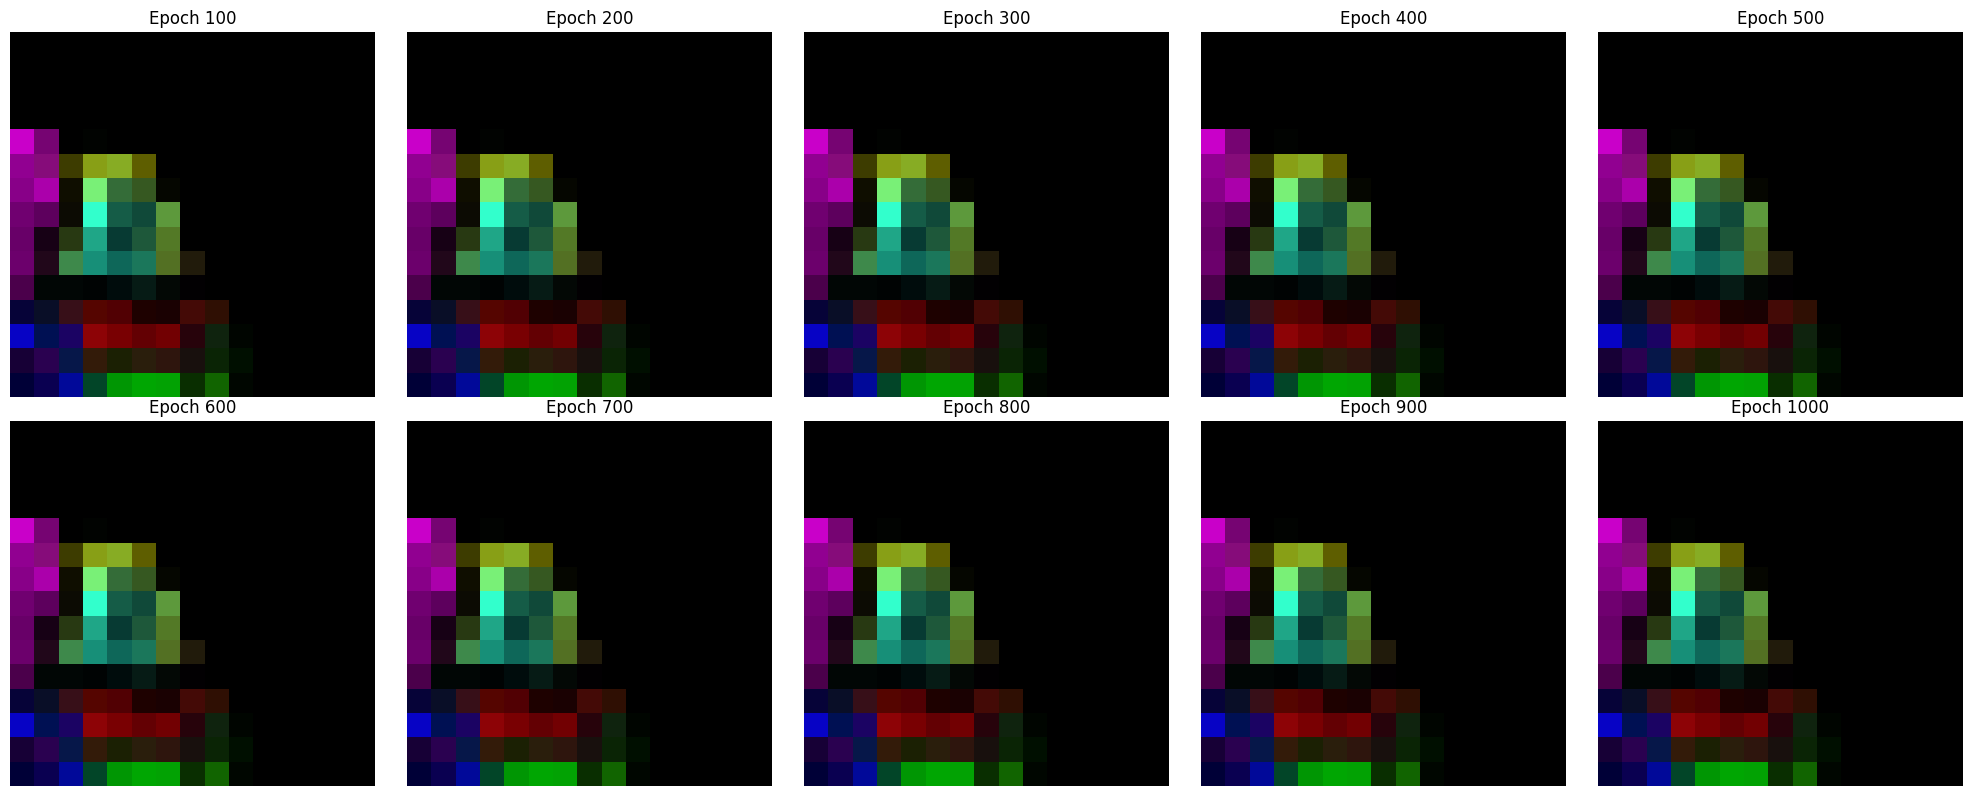

Evaluating clustering effectiveness...
Intra-cluster Distance: 3.7606737051968464
Inter-cluster Distance: 7.694234486526022
Silhouette Score: 0.0016672717092325652
Quantization Error: 3.760673705196859
Reconstruction Error: 3.760673705196859
Purity: 0.8188173609088261
Training completed.


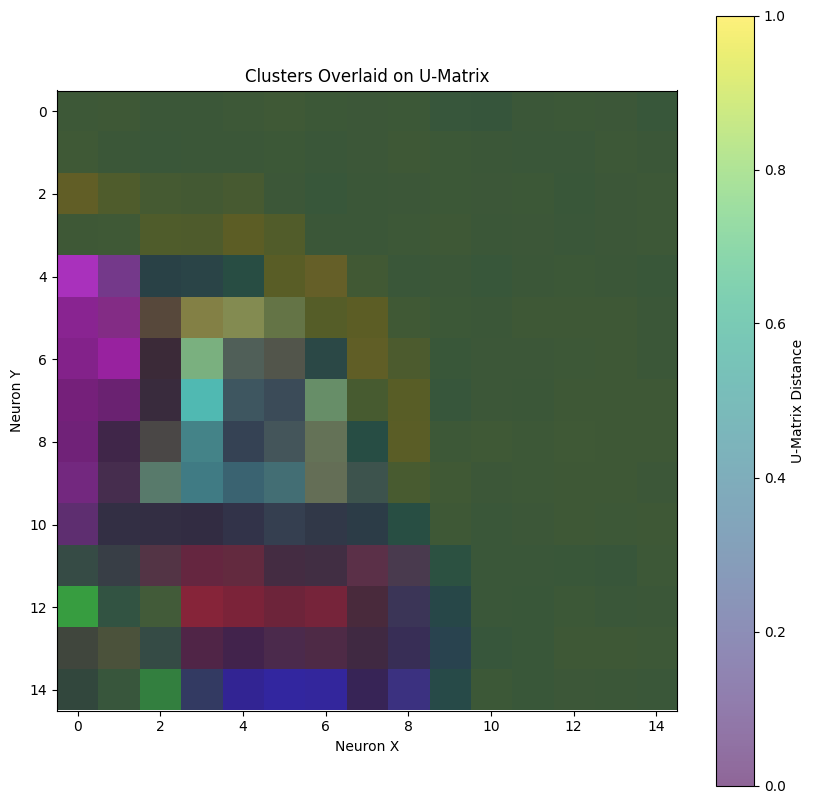

Training SOM with grid size: (20, 20)
Creating combined visualization...


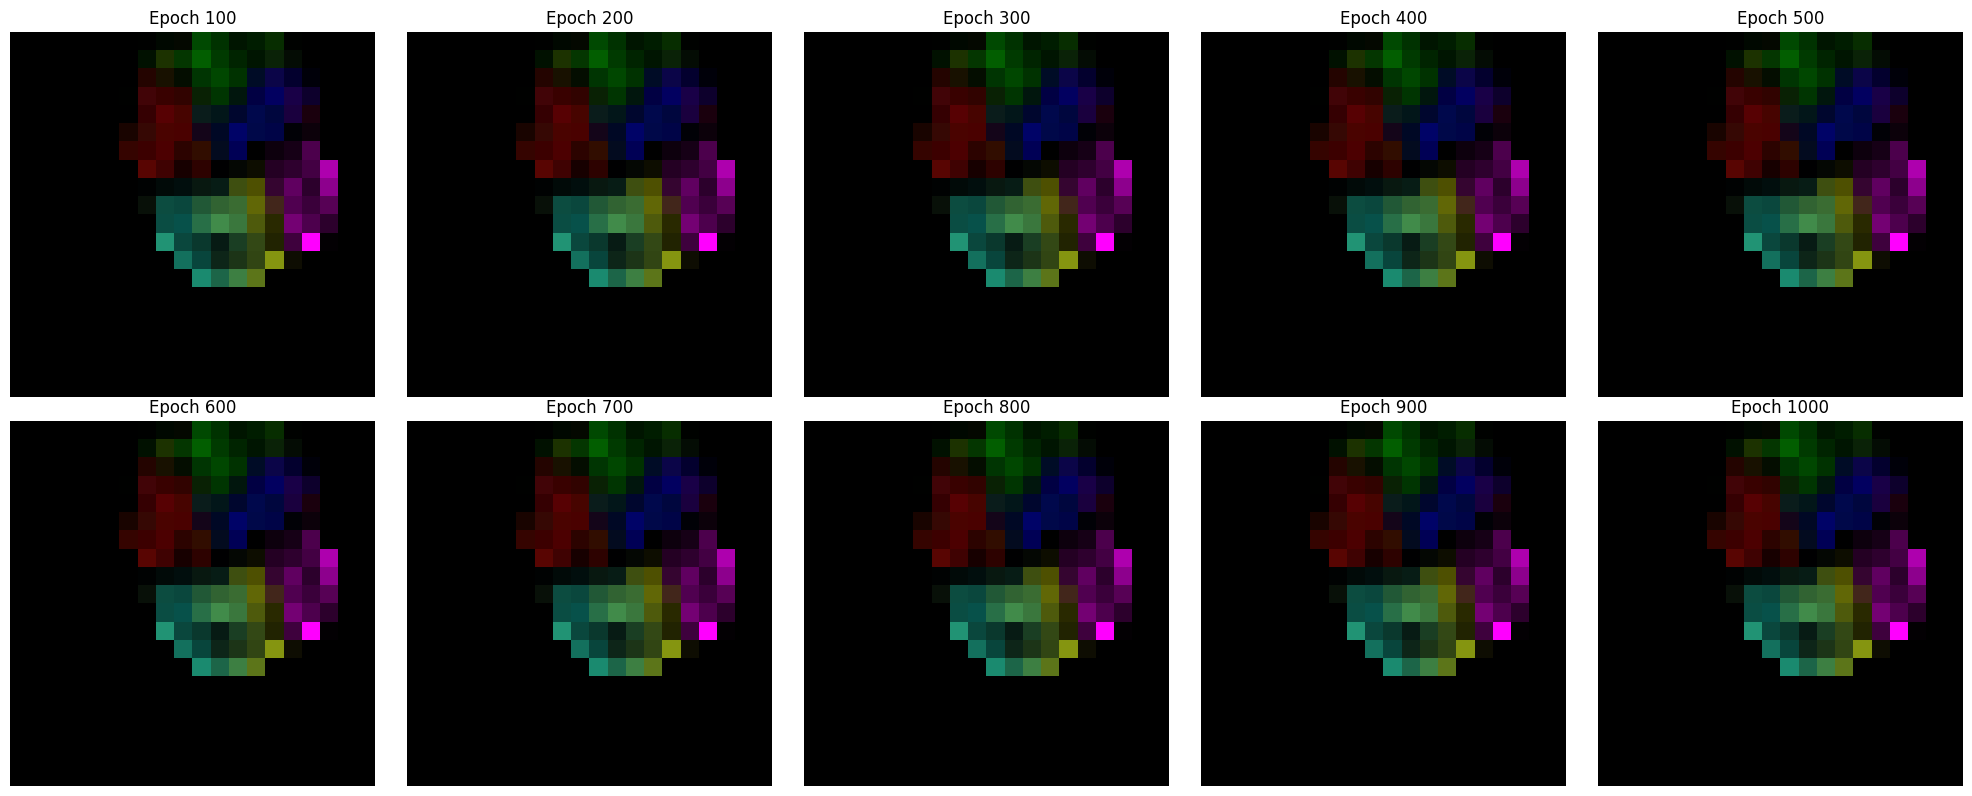

Evaluating clustering effectiveness...
Intra-cluster Distance: 3.6612543264320863
Inter-cluster Distance: 8.034917717609888
Silhouette Score: -0.0030065822527399503
Quantization Error: 3.661254326432072
Reconstruction Error: 3.661254326432072
Purity: 0.8436741431206913
Training completed.


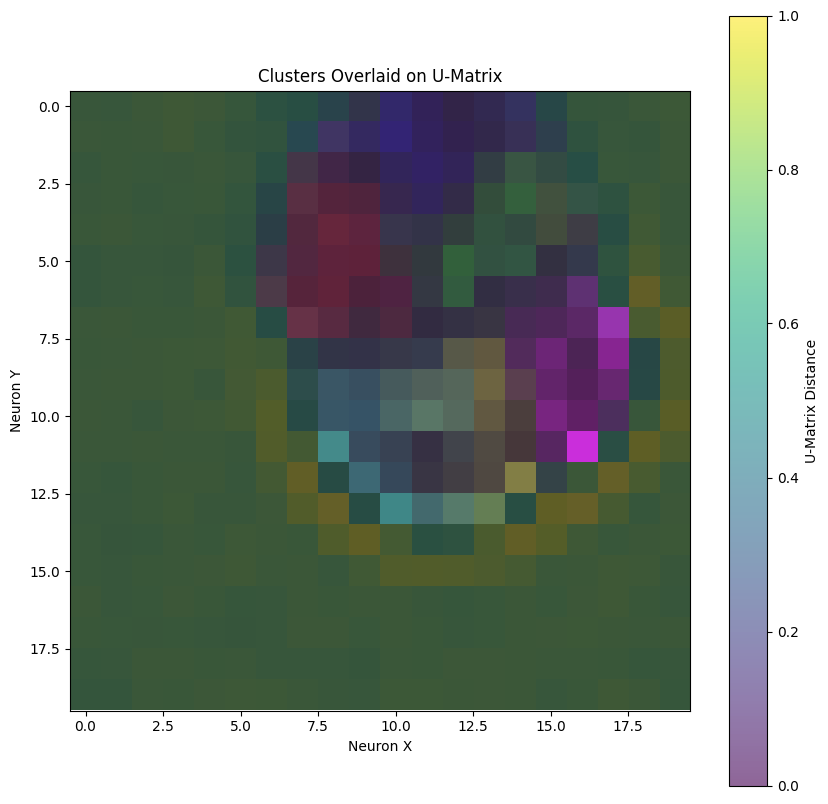

In [13]:
# Function to compute the U-Matrix for a trained SOM
def compute_u_matrix(som):
    rows, cols = som.grid_shape
    u_matrix = np.zeros((rows, cols))

    for i in range(rows):
        for j in range(cols):
            distances = []
            current_weight = som.weights[i, j]
            # Check neighbors (up, down, left, right)
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ni, nj = i + dx, j + dy
                if 0 <= ni < rows and 0 <= nj < cols:
                    neighbor_weight = som.weights[ni, nj]
                    distances.append(np.linalg.norm(current_weight - neighbor_weight))
            u_matrix[i, j] = np.mean(distances) if distances else 0
    return u_matrix

# Function to overlay clusters on U-Matrix
def overlay_clusters_on_u_matrix(som, u_matrix, data, labels):
    rows, cols = som.grid_shape
    cluster_map = np.zeros((rows, cols, 3))  # RGB overlay for clusters

    # Assign cluster colors
    cluster_colors = {
        1: [1, 0, 0],  # Red
        2: [0, 1, 0],  # Green
        3: [0, 0, 1],  # Blue
        4: [1, 1, 0],  # Yellow
        5: [0, 1, 1],  # Cyan
        6: [1, 0, 1],  # Magenta
    }

    # Map each data point to its BMU and accumulate its label color
    for i, sample in enumerate(data.values):
        bmu_idx = som._find_bmu(sample)
        iw, jw = bmu_idx[0], bmu_idx[1]

        # Fix: Access scalar value of the label
        label = labels.iloc[i] if hasattr(labels, "iloc") else labels[i]

        # Ensure labels[i] retrieves the scalar value
        cluster_color = cluster_colors.get(labels.iloc[i].values[0], [0.5, 0.5, 0.5])  # Use .iloc for proper indexing
        cluster_map[iw, jw] += cluster_color

    # Normalize cluster_map to ensure proper RGB display
    cluster_map = cluster_map / np.max(cluster_map)

    # Overlay the cluster map on the U-Matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(u_matrix, cmap='viridis', interpolation='none', alpha=0.7)  # U-Matrix as the base
    plt.imshow(cluster_map, interpolation='none', alpha=0.6)  # Cluster overlay
    plt.colorbar(label="U-Matrix Distance")
    plt.title("Clusters Overlaid on U-Matrix")
    plt.xlabel("Neuron X")
    plt.ylabel("Neuron Y")
    plt.show()



# Train SOM with different grid sizes and visualize clustering on U-Matrix
grid_sizes = [(10, 10), (15, 15), (20, 20)]
best_radius = 1.0  # Based on previous experiments

for grid_size in grid_sizes:
    print(f"Training SOM with grid size: {grid_size}")
    som = SelfOrganizingMap(grid_shape=grid_size, input_dim=data.shape[1], learning_rate=0.5, radius=best_radius, max_iter=1000)
    som.train(data.values, labels.values.flatten())

    # Compute U-Matrix
    u_matrix = compute_u_matrix(som)

    # Overlay clusters on U-Matrix
    overlay_clusters_on_u_matrix(som, u_matrix, data, labels)
